# Load packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.17
fastai     : 2.3.1
fastcore   : 1.3.19
torch      : 1.8.1+cu111


In [3]:
torch.cuda.get_device_name(0)

'GeForce RTX 2070'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import ticker

In [5]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
           'legend.fontsize': med,
           'figure.figsize': (10, 6),
           'axes.labelsize': med,
           'axes.titlesize': med,
           'xtick.labelsize': med,
           'ytick.labelsize': med,
           'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

# Version
print(mpl.__version__)
print(sns.__version__)

3.3.2
0.11.0


In [6]:
import hyperopt
print(hyperopt.__version__)
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp
from hyperopt import space_eval

0.2.5


In [7]:
import time
from fastai.callback.tracker import EarlyStoppingCallback
import gc

In [8]:
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Specify parameters

In [9]:
file_name = "../OD_pair/Abilene-OD_pair.csv"  # the input filename
history = 10  # input historical time steps
horizon = 1  # output predicted time steps
test_ratio = 0.2  # testing data ratio
max_evals = 100  # maximal trials for hyper parameter tuning

model_name = 'TST'
y_true_fn = '%s_true_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)
y_pred_fn = '%s_pred_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)

RMSE_fn = model_name + '_TM-minmax_RMSE-%d-%d-step-%d.pdf'
MAE_fn = model_name + '_TM-minmax_MAE-%d-%d-step-%d.pdf'

In [10]:
y_true_fn

'TST_true_TM-minmax-10-1.pkl'

In [11]:
y_pred_fn

'TST_pred_TM-minmax-10-1.pkl'

# Load data

In [12]:
df = pd.read_csv(file_name)

In [13]:
df.head()

time     OD_1-1      OD_1-2       OD_1-3      OD_1-4  \
0  2004-03-01-00-00  26.666667  522.208000  1641.338667  335.728000   
1  2004-03-01-00-05  26.666667  465.701333   868.098667  148.346667   
2  2004-03-01-00-10  53.333333  375.261333  1082.378667  276.136000   
3  2004-03-01-00-15  67.274667  498.360000  1332.205333  121.269333   
4  2004-03-01-00-20  26.666667  723.962667  1428.480000  165.938667   

       OD_1-5       OD_1-6      OD_1-7       OD_1-8      OD_1-9  ...  \
0  413.032000   489.874667  365.077333   817.869333  452.061333  ...   
1  398.701333  1821.269333  402.144000  1090.848000  585.202667  ...   
2  453.426667  1703.384000  407.152000   403.664000  853.005333  ...   
3  425.168000   794.472000  506.746667   142.328000  818.728000  ...   
4  459.965333   403.757333  303.256000   257.877333  848.208000  ...   

        OD_12-3       OD_12-4       OD_12-5       OD_12-6       OD_12-7  \
0  66541.197333  36063.421333  15439.312000  62781.813333  32642.733333   
1  62246.088000  34109.810667  15664.965333  56823.610667  24912.210667   
2  70181.930667  29905.896000  19918.581333  58658.568000  19036.714667   
3  74490.416000  44822.789333  16250.042667  50589.922667  18758.725333   
4  69881.266667  44536.856000  18448.840000  51095.165333  18614.133333   

         OD_12-8        OD_12-9     OD_12-10      OD_12-11       OD_12-12  
0   91675.626667  133661.405333  1980.576000  29760.202667  187653.482667  
1  100567.461333  137277.728000  4411.589333  30667.266667  190925.981333  
2   92415.480000  153845.554667  5300.653333  39990.880000  218742.773333  
3   97793.093333  159339.533333  4490.272000  38331.688000  265665.077333  
4   93446.560000  151623.424000  3487.808000  43462.373333  210540.786667  

[5 rows x 145 columns]

Parse the time column:

In [14]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d-%H-%M')  # Parse the time

Remove the outliers:

In [15]:
data_columns = list(df.columns.values)
data_columns.remove('time')
data = df[data_columns].values
data = np.clip(data, 0.0, np.percentile(data.flatten(), 99))  # we use 99% as the threshold
df[data_columns] = data

# Split the data

Split the data based on the test_ratio parameter. Aggreate the data and plot the training/testing split first:

In [16]:
aggregated_time_series = np.sum(data, axis=1)
df_ts = pd.DataFrame()
df_ts['date'] = df['time']
df_ts['data'] = aggregated_time_series / 1000  # Plot in Mbps

# add a datetimeindex
dates = pd.DatetimeIndex(df_ts['date'])
df_ts = df_ts.set_index(dates).asfreq('5T') 

In [17]:
test_length = int(df.shape[0] * test_ratio)
train_length = df.shape[0] - test_length

In [18]:
df_ts.index[train_length:][0]

Timestamp('2004-07-12 14:25:00', freq='5T')

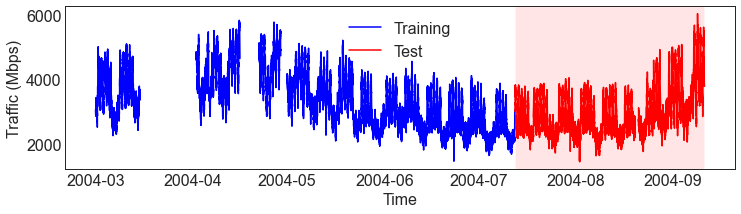

In [19]:
plt.figure(figsize=[12, 3])
plt.plot(df_ts.index[:train_length], df_ts['data'][:train_length], label='Training', color='blue')
plt.plot(df_ts.index[train_length:], df_ts['data'][train_length:], label='Test', color='red')
plt.axvspan(df_ts.index[train_length:][0], df_ts.index[train_length:][-1],  facecolor='r', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Traffic (Mbps)')
plt.legend(loc='best')
# plt.show()
plt.savefig('training_test_split.pdf', bbox_inches = 'tight', pad_inches = 0.1)

Plot the training / testing split:

# Normalize the data

Calculate the min and max data based on the training data set:

In [20]:
max_list = np.max(data[:train_length], axis=0)

In [21]:
min_list = np.min(data[:train_length], axis=0)

Normalize the data and fill the data:

In [22]:
data = (data - min_list) / (max_list - min_list)
data[np.isnan(data)] = 0  # fill the abnormal data with 0
data[np.isinf(data)] = 0

In [23]:
print(np.max(data[:train_length].flatten()))

1.0


In [24]:
print(np.min(data[:train_length].flatten()))

0.0


The training data is in a range of [0, 1] but the test data may be out of this range:

In [25]:
print(np.max(data.flatten()))

5.940447088662937


In [26]:
print(np.min(data.flatten()))

-0.0023245664896374284


# Build the supervised prediction problem

The input data is in the following format:
* x_data as input features: [data size, input historical steps, input channels]. Here the input channel number is the OD pair number.
* y_data as output targets: [data size, output prediction steps, output channels].

In [27]:
x_data = []
y_data = []

In [28]:
length = data.shape[0]
print(length)

48096


In [29]:
for i in range(length - history - horizon + 1):
    x = data[i:i+history, :]  # input historical time steps
    y = data[i+history:i+history+horizon:, :]  # output predicted time steps
    x_data.append(x)
    y_data.append(y)

In [30]:
x_data = np.array(x_data)
y_data = np.array(y_data)

In [31]:
x_data.shape

(48086, 10, 144)

In [32]:
y_data.shape

(48086, 1, 144)

Reshape x_data:

In [33]:
x_data = np.swapaxes(x_data, 1, 2)

Reshape y_data:

In [34]:
y_data = y_data.reshape(y_data.shape[0], -1)
y_data.shape

(48086, 144)

The last test_length samples are fixed as test data. The training data size may vary with the input historical time steps. The test data size may vary with the prediction horizon.

In [35]:
test_length = test_length - horizon + 1

In [36]:
train_valid_length = x_data.shape[0] - test_length

In [37]:
train_valid_length

38467

We further split a valid data set for hyper parameter tuning:

In [38]:
train_length = int(train_valid_length * 0.8)
valid_length = train_valid_length - train_length

In [39]:
train_length

30773

In [40]:
valid_length

7694

In [41]:
X_train = x_data[:train_length]
y_train = y_data[:train_length]
X_valid = x_data[train_length:train_valid_length]
y_valid = y_data[train_length:train_valid_length]
X_test = x_data[train_valid_length:]
y_test = y_data[train_valid_length:]

In [42]:
X_train.shape

(30773, 144, 10)

In [43]:
y_train.shape

(30773, 144)

In [44]:
X_valid.shape

(7694, 144, 10)

In [45]:
y_valid.shape

(7694, 144)

In [46]:
X_test.shape

(9619, 144, 10)

In [47]:
y_test.shape

(9619, 144)

# Build TSAI Datasets

Now we are ready to use the tsai package with its dataset definition:

In [48]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [49]:
X.shape

(38467, 144, 10)

In [50]:
y.shape

(38467, 144)

In [51]:
splits

((#30773) [0,1,2,3,4,5,6,7,8,9...],
 (#7694) [30773,30774,30775,30776,30777,30778,30779,30780,30781,30782...])

Make sure this is a regression task, instead of a classification task (using TSRegression as follows):

In [52]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#38467) [(TSTensor(vars:144, len:10), tensor([2.0469e-03, 5.1440e-02, 1.4299e-01, 1.5172e-02, 3.1831e-02, 2.1060e-02,
        5.6545e-02, 2.7428e-02, 2.8036e-01, 0.0000e+00, 4.0722e-02, 8.6615e-02,
        5.2351e-02, 2.0172e-01, 2.2308e-01, 5.7753e-02, 2.0265e-02, 1.5293e-01,
        9.8783e-02, 1.2363e-01, 1.7657e-01, 3.3181e-02, 2.1478e-01, 3.0738e-01,
        9.3064e-02, 9.6376e-02, 1.5660e-01, 3.1830e-02, 4.6944e-02, 1.3623e-01,
        4.7996e-02, 9.0038e-02, 3.8663e-02, 3.1614e-02, 1.1989e-01, 4.8892e-02,
        7.9847e-03, 2.8893e-02, 1.8501e-01, 3.5594e-02, 1.7775e-02, 6.8981e-02,
        8.2558e-02, 8.7485e-02, 1.3270e-01, 7.0169e-02, 1.0452e-01, 2.8641e-02,
        2.3876e-01, 3.3501e-02, 1.7263e-01, 9.0359e-02, 4.2771e-02, 4.5059e-01,
        2.0892e-01, 1.9877e-02, 5.5563e-02, 1.0113e-01, 1.0701e-01, 3.5482e-02,
        1.2049e-01, 1.0425e-01, 4.3749e-01, 9.8969e-02, 7.4077e-02, 9.2987e-02,
        1.2642e-01, 1.1211e-01, 1.5237e-01, 7.5094e-02, 2.2026e-01, 1.6917e-01,
 

# Model Building and Hyperparameter Tuning

We use the hyperopt package to search for hyper parameters:

In [53]:
search_space = {
    'batch_size': hp.choice('bs', [16, 32, 64, 128]),
    "lr": hp.choice('lr', [0.1, 0.01, 0.001]),
    "epochs": hp.choice('epochs', [20, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    # "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    "optimizer": hp.choice('optimizer', [Adam]),
    # model parameters
    "n_layers": hp.choice('n_layers', [1, 2, 3, 4, 5]),
    "d_model": hp.choice('d_model', [64, 128, 256]),
    "n_heads": hp.choice('n_heads', [8, 16, 32])
}

In [54]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x25400012488>,
 'lr': <hyperopt.pyll.base.Apply at 0x2540000dc88>,
 'epochs': <hyperopt.pyll.base.Apply at 0x2540000d288>,
 'patience': <hyperopt.pyll.base.Apply at 0x2540000dc48>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x25400123388>,
 'n_layers': <hyperopt.pyll.base.Apply at 0x2540011acc8>,
 'd_model': <hyperopt.pyll.base.Apply at 0x254000fe208>,
 'n_heads': <hyperopt.pyll.base.Apply at 0x25469771188>}

In [55]:
# clear memory 
gc.collect()

0

In [56]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:", params)
        batch_size = params["batch_size"]
    
        # Create data loader
        tfms  = [None, [TSRegression()]]
        dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = TST
        k = {
            'n_layers': params['n_layers'],
            'd_model': params['d_model'],
            'n_heads': params['n_heads']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
        
        # Add a Sigmoid layer
        model = nn.Sequential(model, nn.Sigmoid())
    
        # Training the model
        learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
        print(elapsed)
    
        vals = learn.recorder.values[-1]
        print(vals)
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 64, 'epochs': 20, 'lr': 0.01, 'n_heads': 8, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 10}
TST                                                                                                                    
  0%|                                                                          | 0/100 [00:06<?, ?trial/s, best loss=?]

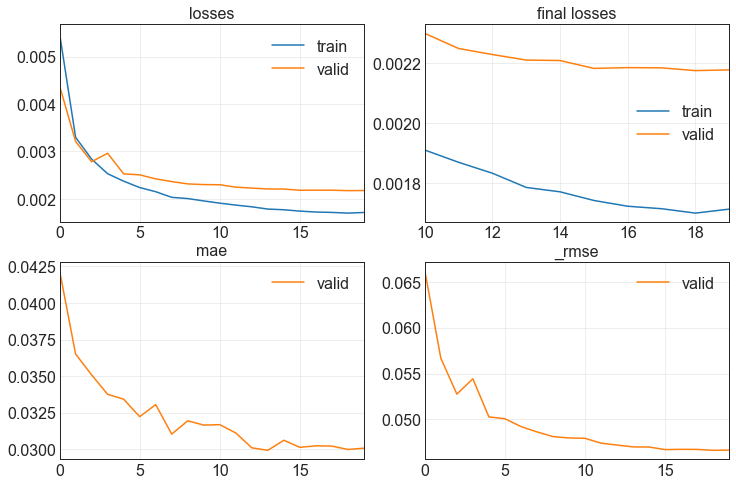

69.2264814376831                                                                                                       
[0.001713826903142035, 0.002176815876737237, 0.030067341402173042, 0.04665636271238327]                                
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 100, 'lr': 0.1, 'n_heads': 16, 'n_layers': 1, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 10}
TST                                                                                                                    
  1%|▍                                           | 1/100 [01:20<2:05:21, 75.98s/trial, best loss: 0.002176815876737237]

No improvement since epoch 14: early stopping                                                                          
  1%|▍                                           | 1/100 [04:53<2:05:21, 75.98s/trial, best loss: 0.002176815876737237]

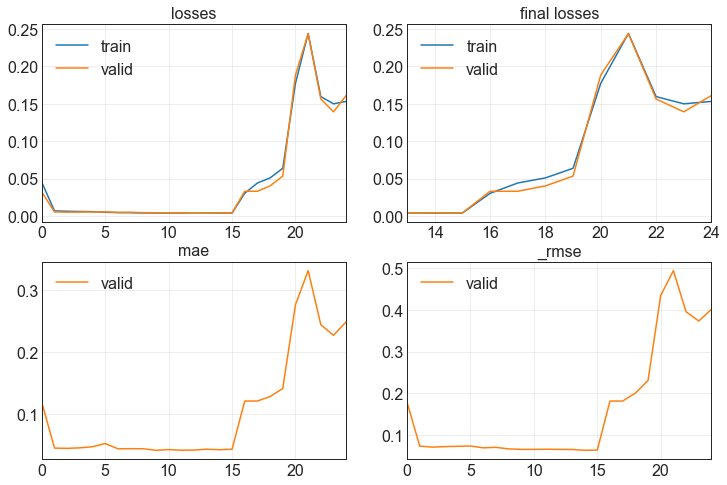

212.92466235160828                                                                                                     
[0.15319375693798065, 0.16107328236103058, 0.24858911335468292, 0.4013393819332123]                                    
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 128, 'epochs': 50, 'lr': 0.1, 'n_heads': 32, 'n_layers': 1, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
  2%|▊                                          | 2/100 [04:58<3:13:35, 118.53s/trial, best loss: 0.002176815876737237]

No improvement since epoch 7: early stopping                                                                           
  2%|▊                                          | 2/100 [05:29<3:13:35, 118.53s/trial, best loss: 0.002176815876737237]

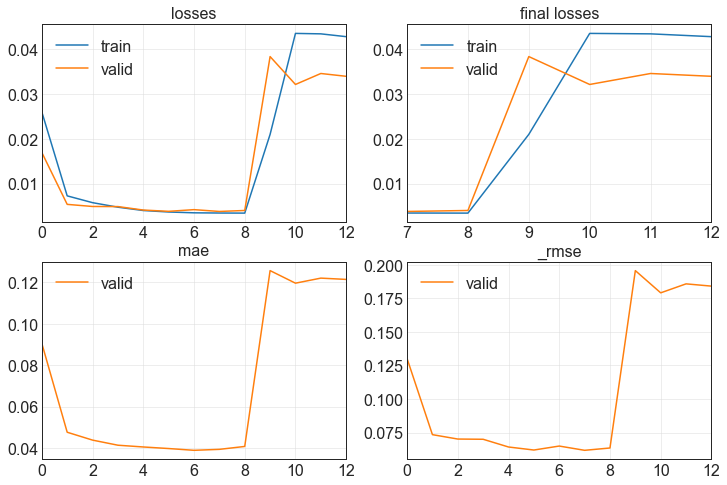

31.321054220199585                                                                                                     
[0.04270971566438675, 0.03389011323451996, 0.12140591442584991, 0.1840926706790924]                                    
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 64, 'epochs': 100, 'lr': 0.1, 'n_heads': 16, 'n_layers': 5, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 10}
TST                                                                                                                    
  3%|█▎                                          | 3/100 [05:35<2:31:47, 93.90s/trial, best loss: 0.002176815876737237]

No improvement since epoch 8: early stopping                                                                           
  3%|█▎                                          | 3/100 [13:14<2:31:47, 93.90s/trial, best loss: 0.002176815876737237]

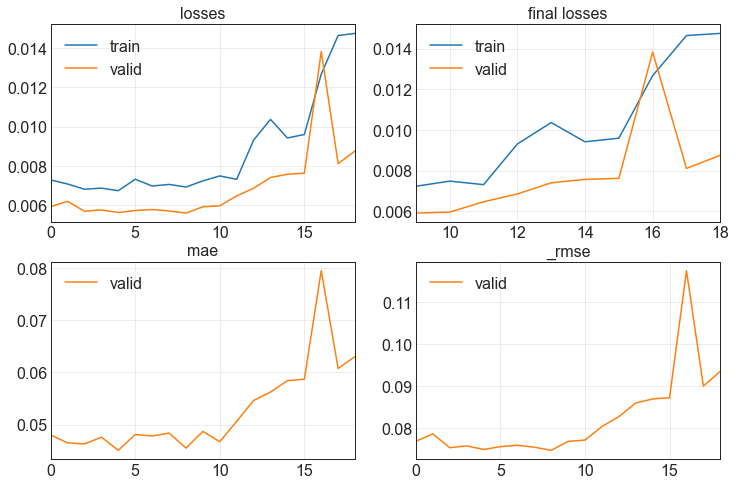

459.6147344112396                                                                                                      
[0.014749272726476192, 0.008757230825722218, 0.063001848757267, 0.09358007460832596]                                   
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 128, 'epochs': 50, 'lr': 0.01, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 10}
TST                                                                                                                    
  4%|█▋                                         | 4/100 [13:19<5:28:09, 205.10s/trial, best loss: 0.002176815876737237]

No improvement since epoch 36: early stopping                                                                          
  4%|█▋                                         | 4/100 [29:30<5:28:09, 205.10s/trial, best loss: 0.002176815876737237]

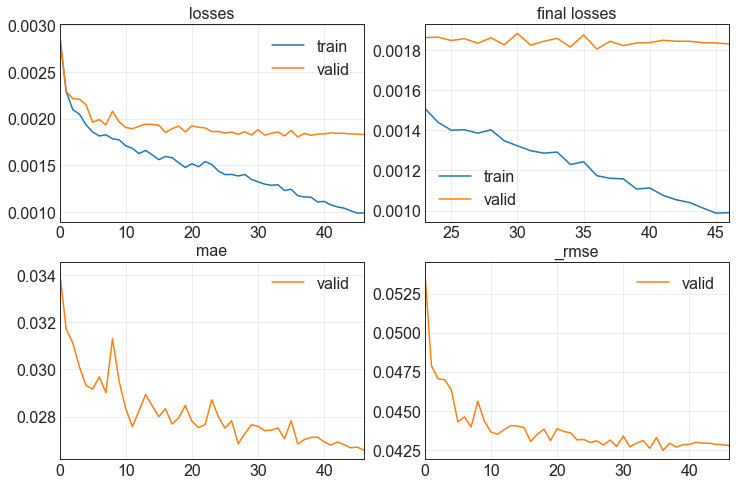

970.854523897171                                                                                                       
[0.0009898801799863577, 0.001829200075007975, 0.02657412178814411, 0.04276914522051811]                                
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 128, 'epochs': 20, 'lr': 0.1, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
  5%|██                                        | 5/100 [29:35<11:30:46, 436.28s/trial, best loss: 0.001829200075007975]

No improvement since epoch 1: early stopping                                                                           
  5%|██                                        | 5/100 [30:13<11:30:46, 436.28s/trial, best loss: 0.001829200075007975]

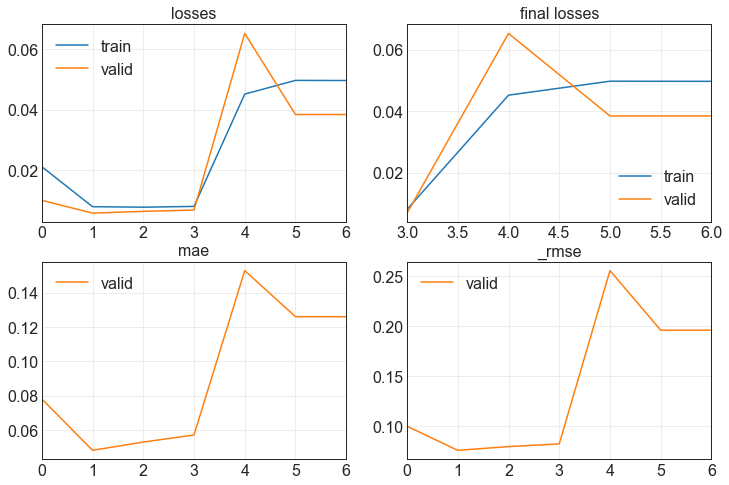

38.85779166221619                                                                                                      
[0.04965564236044884, 0.03840918838977814, 0.12592501938343048, 0.19598262012004852]                                   
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
  6%|██▌                                        | 6/100 [30:19<8:18:59, 318.50s/trial, best loss: 0.001829200075007975]

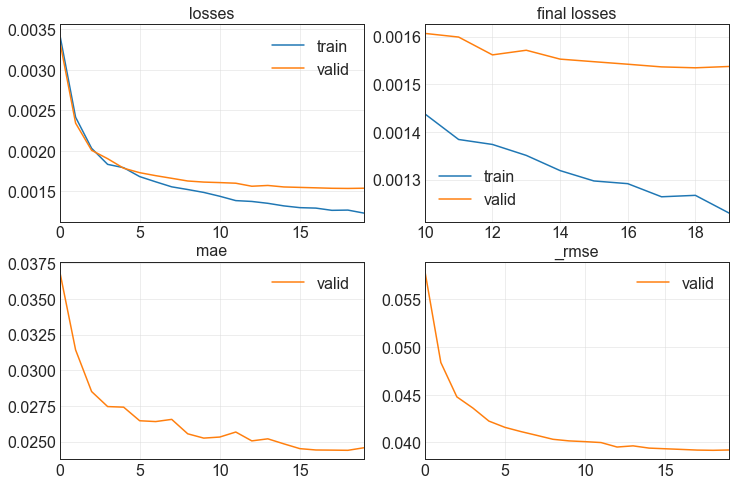

319.0581567287445                                                                                                      
[0.0012298790970817208, 0.0015373300993815064, 0.024576889351010323, 0.039208799600601196]                             
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 128, 'epochs': 100, 'lr': 0.001, 'n_heads': 16, 'n_layers': 3, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
  7%|██▉                                       | 7/100 [35:43<8:16:18, 320.20s/trial, best loss: 0.0015373300993815064]

No improvement since epoch 41: early stopping                                                                          
  7%|██▉                                       | 7/100 [42:12<8:16:18, 320.20s/trial, best loss: 0.0015373300993815064]

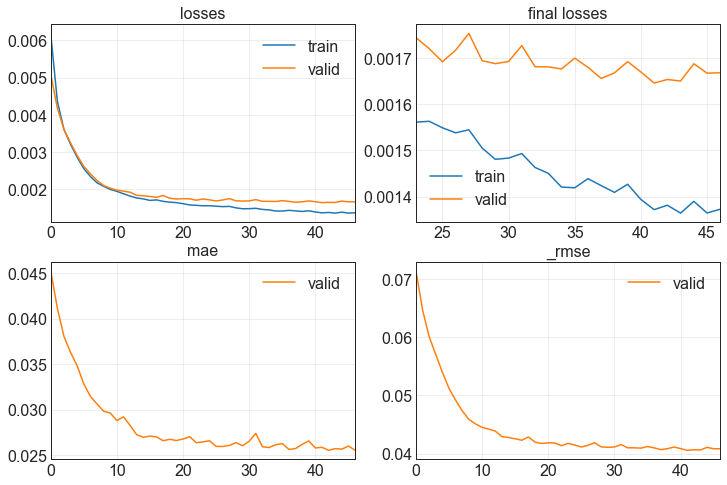

390.3254973888397                                                                                                      
[0.001372746773995459, 0.001667637494392693, 0.0255240760743618, 0.04083671793341637]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 5, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 10}
TST                                                                                                                    
  8%|███▎                                      | 8/100 [42:18<8:45:24, 342.65s/trial, best loss: 0.0015373300993815064]

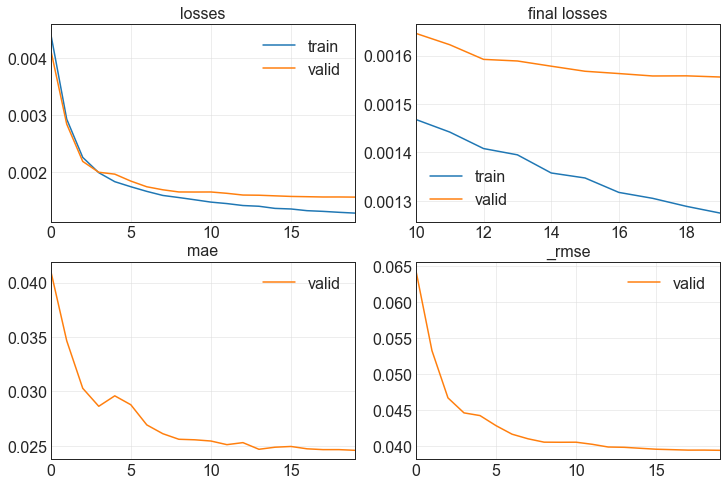

239.70550894737244                                                                                                     
[0.0012748524313792586, 0.0015557612059637904, 0.024577679112553596, 0.03944314271211624]                              
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 256, 'epochs': 50, 'lr': 0.01, 'n_heads': 8, 'n_layers': 3, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
  9%|███▊                                      | 9/100 [46:22<7:55:02, 313.22s/trial, best loss: 0.0015373300993815064]

No improvement since epoch 22: early stopping                                                                          
  9%|███▊                                      | 9/100 [48:35<7:55:02, 313.22s/trial, best loss: 0.0015373300993815064]

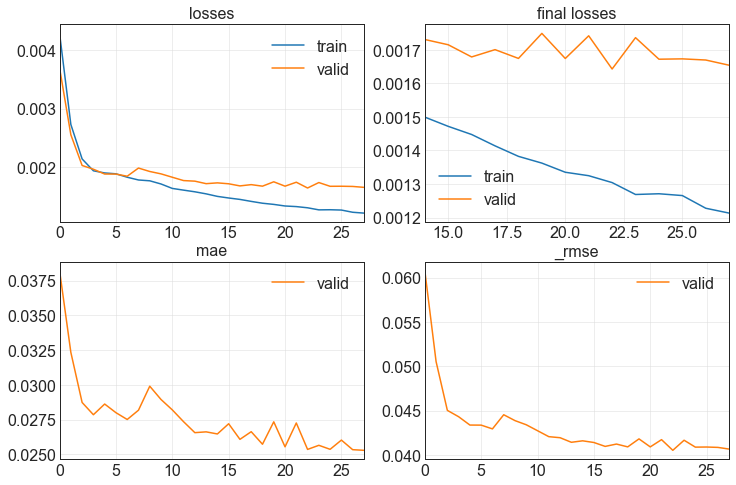

133.78090739250183                                                                                                     
[0.0012134249554947019, 0.0016540283104404807, 0.02528182417154312, 0.040669746696949005]                              
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 256, 'epochs': 50, 'lr': 0.1, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 10%|████                                     | 10/100 [48:41<6:31:13, 260.82s/trial, best loss: 0.0015373300993815064]

No improvement since epoch 7: early stopping                                                                           
 10%|████                                     | 10/100 [49:59<6:31:13, 260.82s/trial, best loss: 0.0015373300993815064]

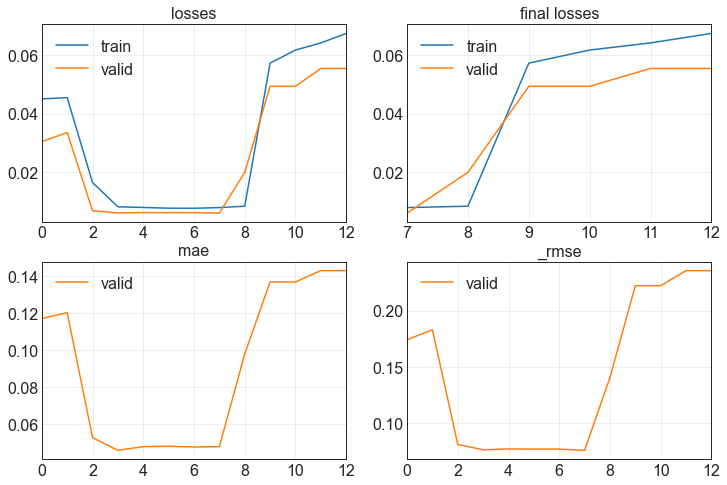

78.09966707229614                                                                                                      
[0.06755676865577698, 0.05550037696957588, 0.14301615953445435, 0.23558515310287476]                                   
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 128, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 10}
TST                                                                                                                    
 11%|████▌                                    | 11/100 [50:04<5:07:48, 207.51s/trial, best loss: 0.0015373300993815064]

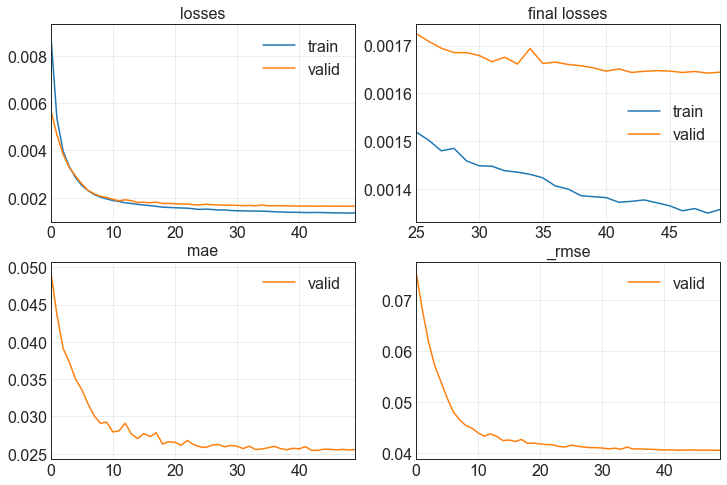

280.60335874557495                                                                                                     
[0.0013585337437689304, 0.0016444920329377055, 0.025557206943631172, 0.04055233299732208]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 100, 'lr': 0.01, 'n_heads': 8, 'n_layers': 5, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 10}
TST                                                                                                                    
 12%|████▉                                    | 12/100 [54:49<5:38:36, 230.87s/trial, best loss: 0.0015373300993815064]

No improvement since epoch 5: early stopping                                                                           
 12%|████▋                                  | 12/100 [1:07:10<5:38:36, 230.87s/trial, best loss: 0.0015373300993815064]

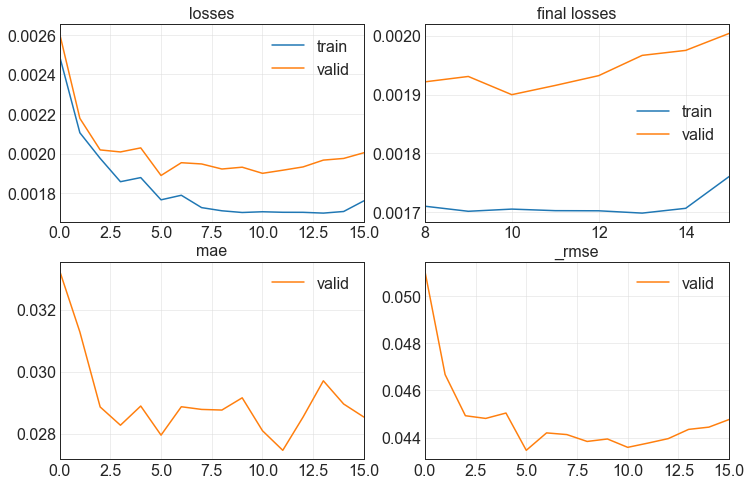

741.4700262546539                                                                                                      
[0.0017606631154194474, 0.0020039279479533434, 0.028529567644000053, 0.044765256345272064]                             
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 50, 'lr': 0.01, 'n_heads': 16, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 10}
TST                                                                                                                    
 13%|█████                                  | 13/100 [1:07:16<9:19:01, 385.53s/trial, best loss: 0.0015373300993815064]

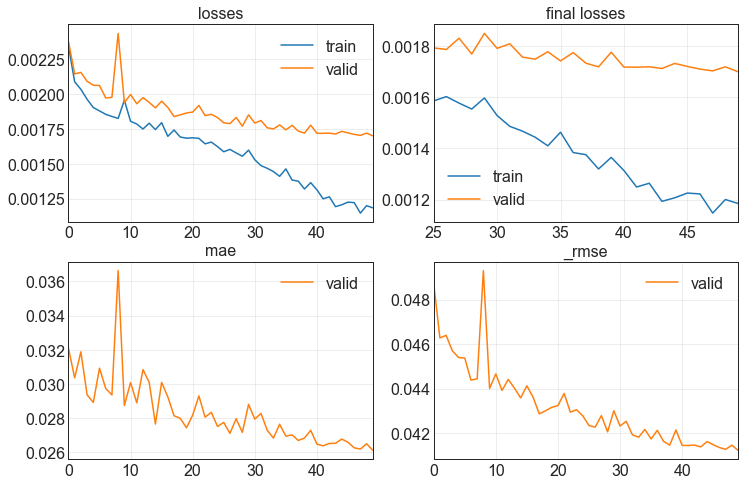

1196.9978020191193                                                                                                     
[0.0011847601272165775, 0.0016994643956422806, 0.026112990453839302, 0.041224561631679535]                             
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 100, 'lr': 0.01, 'n_heads': 8, 'n_layers': 3, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 10}
TST                                                                                                                    
 14%|█████▎                                | 14/100 [1:27:18<15:03:37, 630.44s/trial, best loss: 0.0015373300993815064]

No improvement since epoch 12: early stopping                                                                          
 14%|█████▎                                | 14/100 [1:39:19<15:03:37, 630.44s/trial, best loss: 0.0015373300993815064]

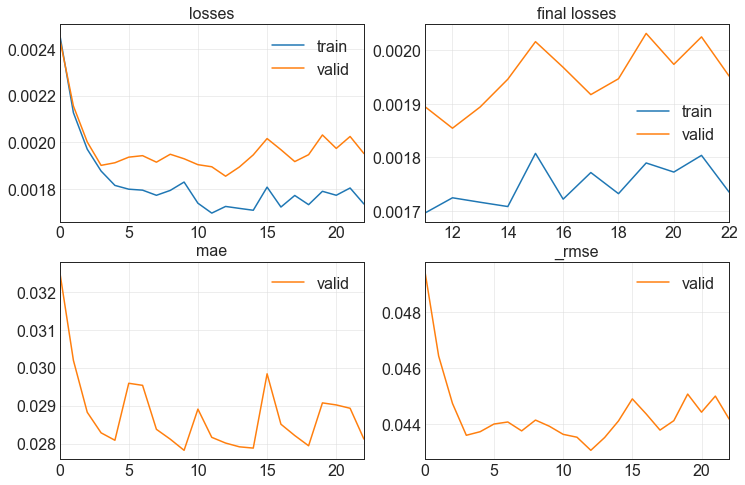

721.3333723545074                                                                                                      
[0.0017353127477690578, 0.001951612182892859, 0.028117362409830093, 0.04417705908417702]                               
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 64, 'epochs': 50, 'lr': 0.1, 'n_heads': 32, 'n_layers': 1, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 15%|█████▋                                | 15/100 [1:39:24<15:33:51, 659.20s/trial, best loss: 0.0015373300993815064]

No improvement since epoch 1: early stopping                                                                           
 15%|█████▋                                | 15/100 [1:40:21<15:33:51, 659.20s/trial, best loss: 0.0015373300993815064]

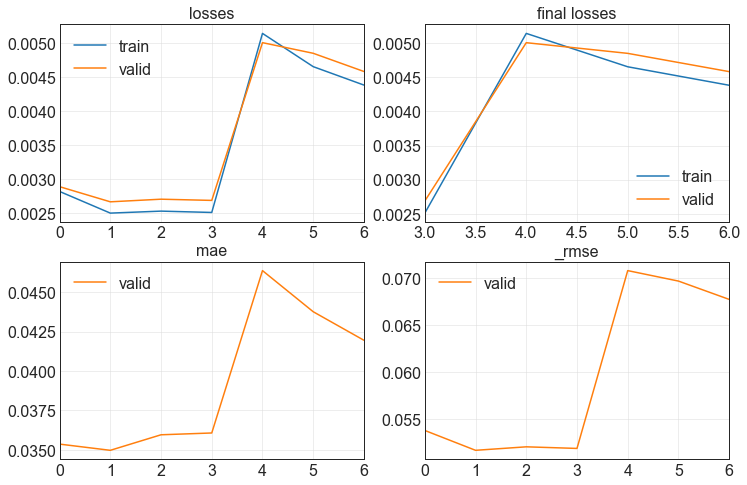

57.237160205841064                                                                                                     
[0.00438346154987812, 0.004583244677633047, 0.04194874316453934, 0.06769967079162598]                                  
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 256, 'epochs': 20, 'lr': 0.1, 'n_heads': 32, 'n_layers': 5, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 16%|██████                                | 16/100 [1:40:26<11:12:03, 480.04s/trial, best loss: 0.0015373300993815064]

No improvement since epoch 1: early stopping                                                                           
 16%|██████                                | 16/100 [1:41:11<11:12:03, 480.04s/trial, best loss: 0.0015373300993815064]

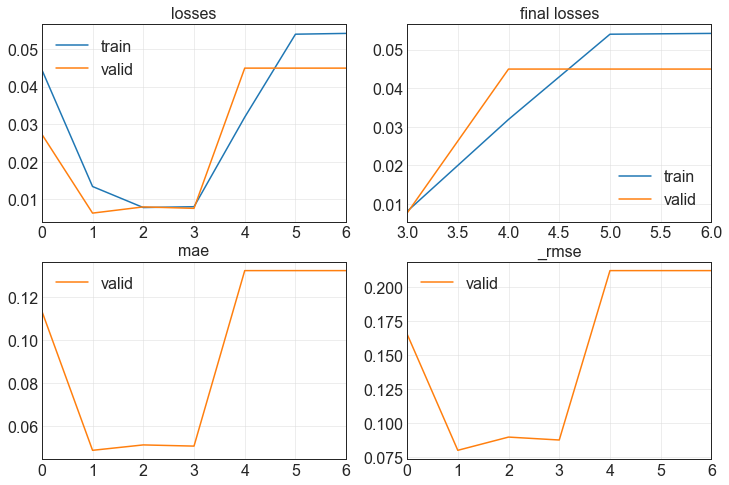

46.24252462387085                                                                                                      
[0.05417921394109726, 0.04494548588991165, 0.1324613094329834, 0.21200352907180786]                                    
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 256, 'epochs': 100, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 10}
TST                                                                                                                    
 17%|██████▋                                | 17/100 [1:41:17<8:05:57, 351.29s/trial, best loss: 0.0015373300993815064]

No improvement since epoch 42: early stopping                                                                          
 17%|██████▋                                | 17/100 [1:45:10<8:05:57, 351.29s/trial, best loss: 0.0015373300993815064]

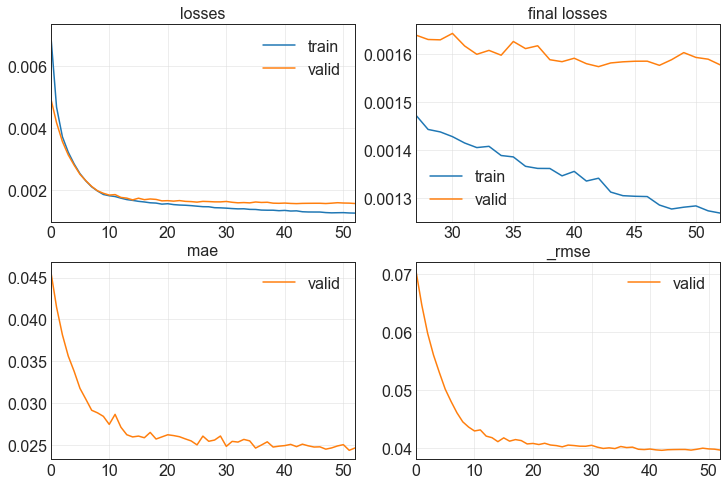

234.19696974754333                                                                                                     
[0.0012680479558184743, 0.001577486633323133, 0.024639630690217018, 0.03971758484840393]                               
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 256, 'epochs': 100, 'lr': 0.1, 'n_heads': 8, 'n_layers': 1, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 10}
TST                                                                                                                    
 18%|███████                                | 18/100 [1:45:15<7:13:59, 317.55s/trial, best loss: 0.0015373300993815064]

No improvement since epoch 13: early stopping                                                                          
 18%|███████                                | 18/100 [1:46:10<7:13:59, 317.55s/trial, best loss: 0.0015373300993815064]

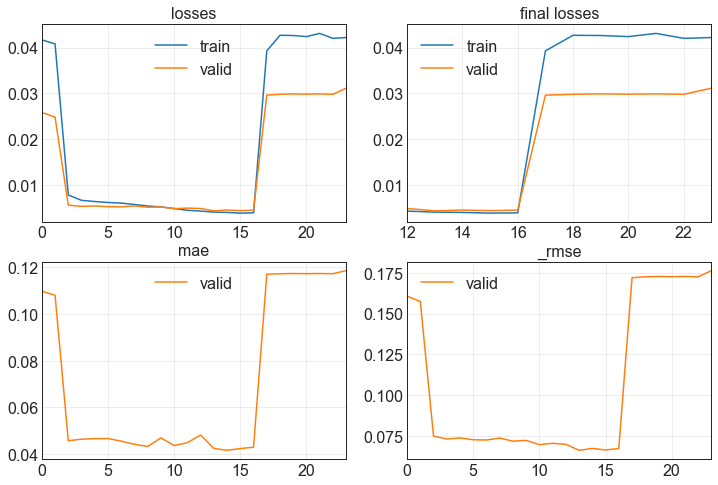

55.05967855453491                                                                                                      
[0.042203474789857864, 0.031136665493249893, 0.11865198612213135, 0.17645584046840668]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 128, 'epochs': 50, 'lr': 0.001, 'n_heads': 8, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 19%|███████▍                               | 19/100 [1:46:15<5:24:14, 240.18s/trial, best loss: 0.0015373300993815064]

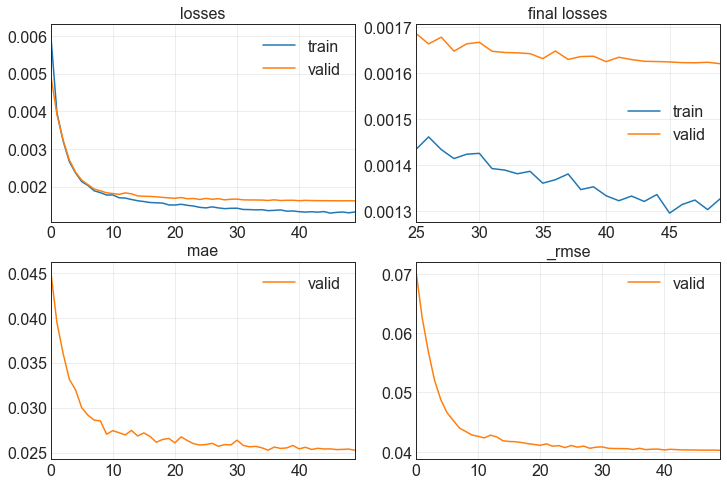

309.1633071899414                                                                                                      
[0.001326268189586699, 0.001619825721718371, 0.025250285863876343, 0.04024706035852432]                                
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 5, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 20%|███████▊                               | 20/100 [1:51:29<5:49:39, 262.24s/trial, best loss: 0.0015373300993815064]

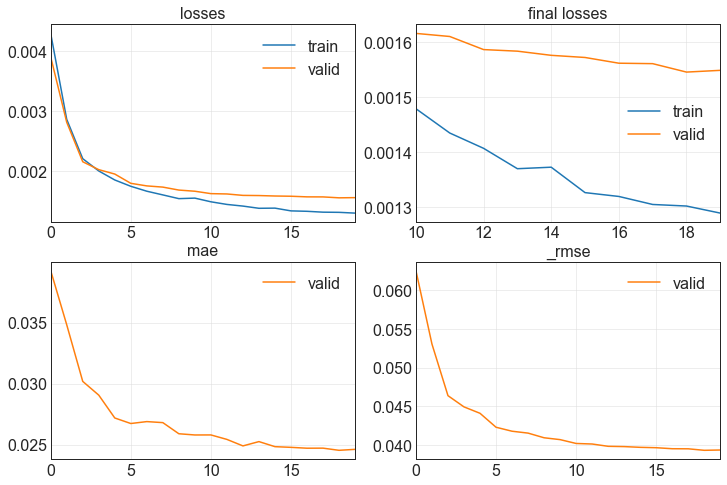

237.61164379119873                                                                                                     
[0.001289317267946899, 0.001548777217976749, 0.02460792288184166, 0.03935450688004494]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 21%|████████▏                              | 21/100 [1:55:31<5:37:29, 256.32s/trial, best loss: 0.0015373300993815064]

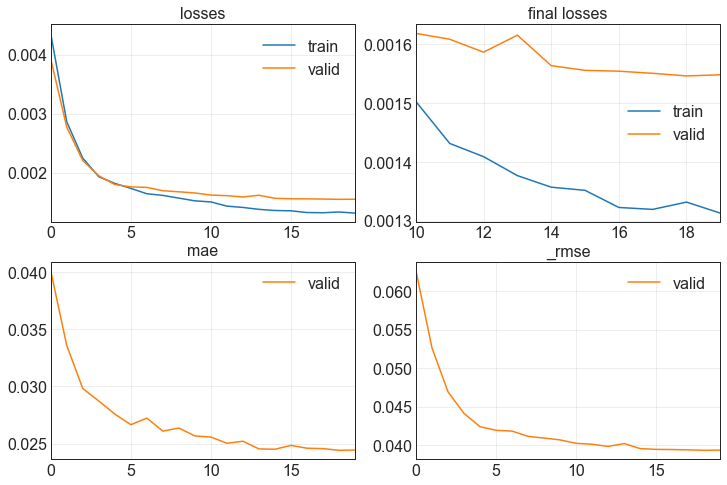

163.71194529533386                                                                                                     
[0.0013128501595929265, 0.0015480723232030869, 0.024441951885819435, 0.039345547556877136]                             
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 22%|████████▌                              | 22/100 [1:58:20<4:58:58, 229.98s/trial, best loss: 0.0015373300993815064]

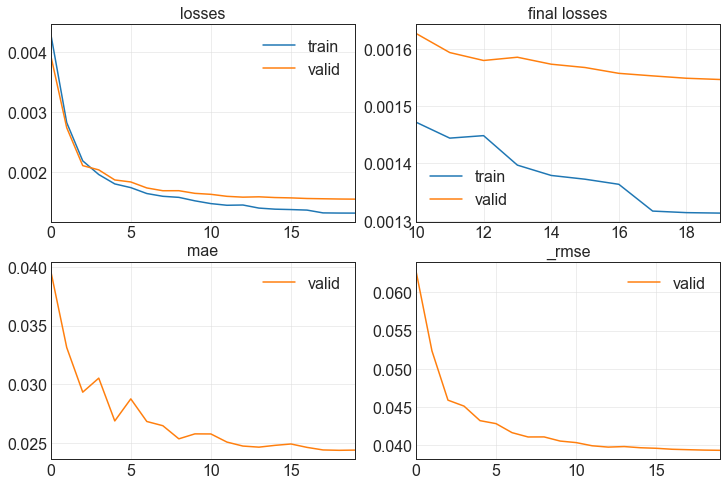

165.7852063179016                                                                                                      
[0.0013133687898516655, 0.0015465572942048311, 0.024427074939012527, 0.039326295256614685]                             
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 23%|████████▉                              | 23/100 [2:01:11<4:32:17, 212.17s/trial, best loss: 0.0015373300993815064]

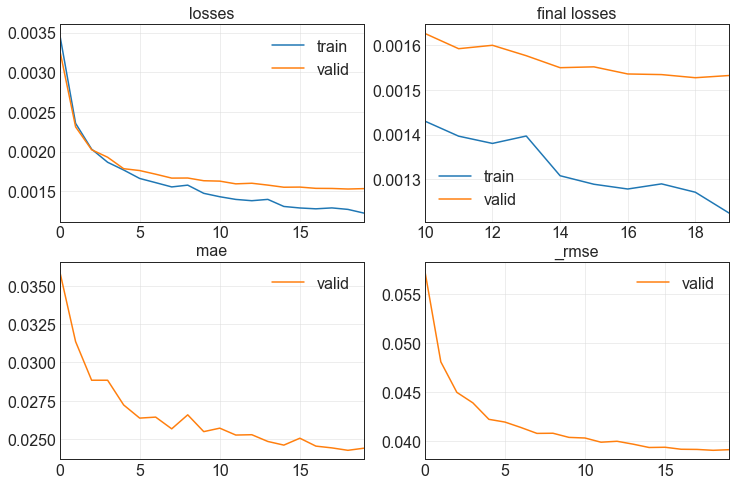

327.8306427001953                                                                                                      
[0.0012240636860951781, 0.0015326489228755236, 0.02440209873020649, 0.03914906829595566]                               
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 24%|█████████▎                             | 24/100 [2:06:43<5:14:33, 248.34s/trial, best loss: 0.0015326489228755236]

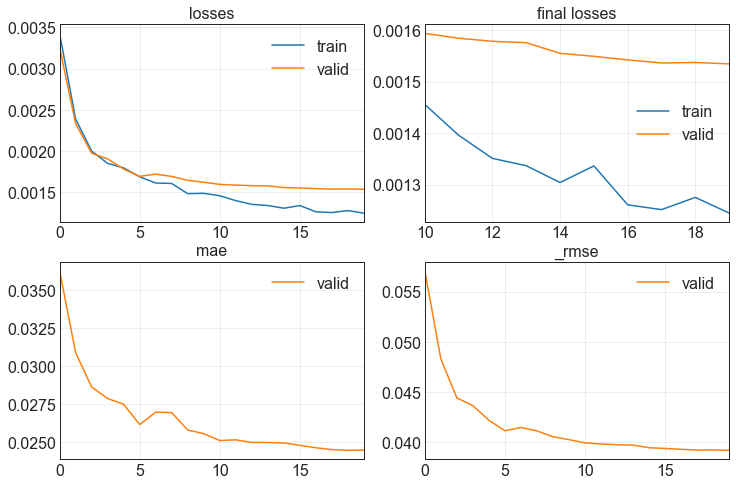

325.8687438964844                                                                                                      
[0.0012445333413779736, 0.0015344948042184114, 0.024460718035697937, 0.039172615855932236]                             
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 64, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 25%|█████████▊                             | 25/100 [2:12:14<5:41:21, 273.09s/trial, best loss: 0.0015326489228755236]

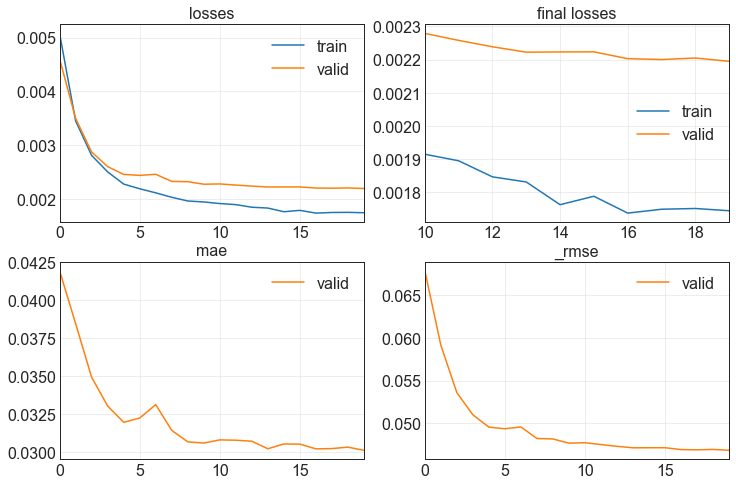

326.76897644996643                                                                                                     
[0.0017438160721212626, 0.0021948597859591246, 0.030139226466417313, 0.046849325299263]                                
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 26%|██████████▏                            | 26/100 [2:17:46<5:58:33, 290.73s/trial, best loss: 0.0015326489228755236]

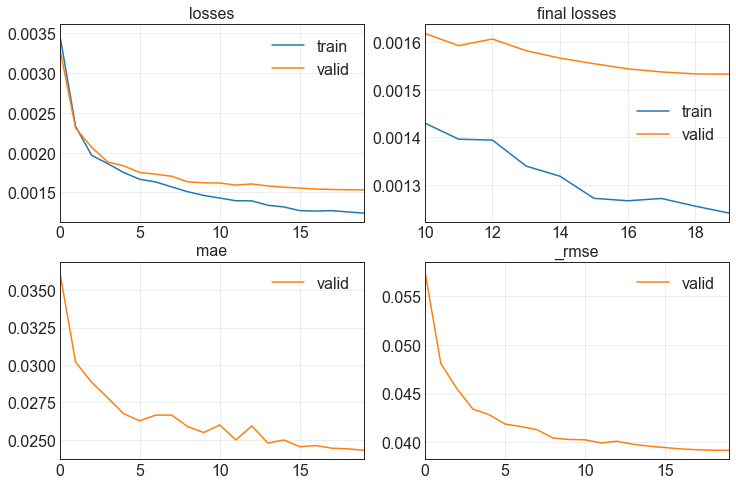

325.3669590950012                                                                                                      
[0.0012408050242811441, 0.0015332618495449424, 0.024301009252667427, 0.03915688768029213]                              
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 27%|██████████▌                            | 27/100 [2:23:17<6:08:09, 302.59s/trial, best loss: 0.0015326489228755236]

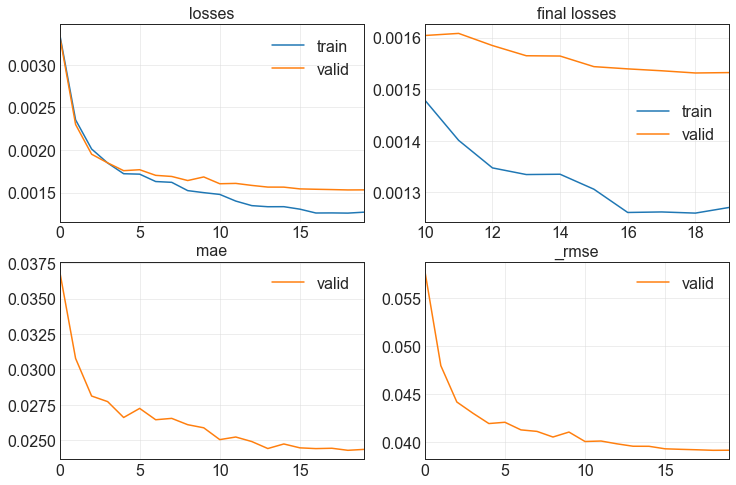

314.92891097068787                                                                                                     
[0.0012707500718533993, 0.0015323582338169217, 0.024369899183511734, 0.039145346730947495]                             
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 64, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 28%|██████████▉                            | 28/100 [2:28:36<6:09:22, 307.81s/trial, best loss: 0.0015323582338169217]

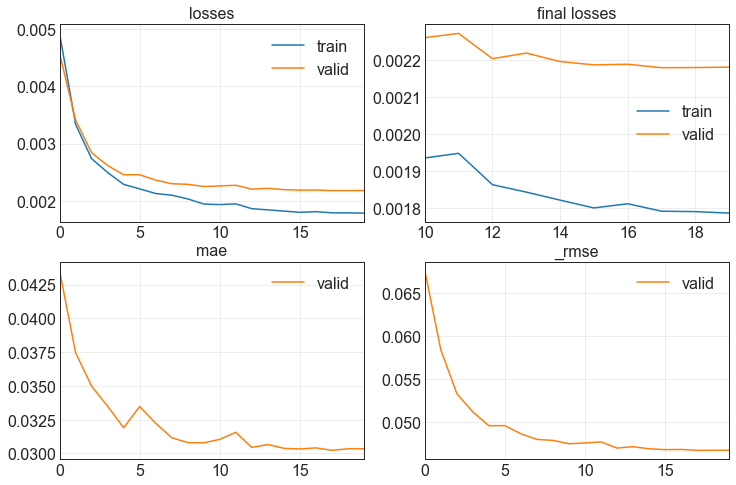

240.23153567314148                                                                                                     
[0.0017870841547846794, 0.002181865507736802, 0.030348539352416992, 0.04671043902635574]                               
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 29%|███████████▎                           | 29/100 [2:32:41<5:41:54, 288.94s/trial, best loss: 0.0015323582338169217]

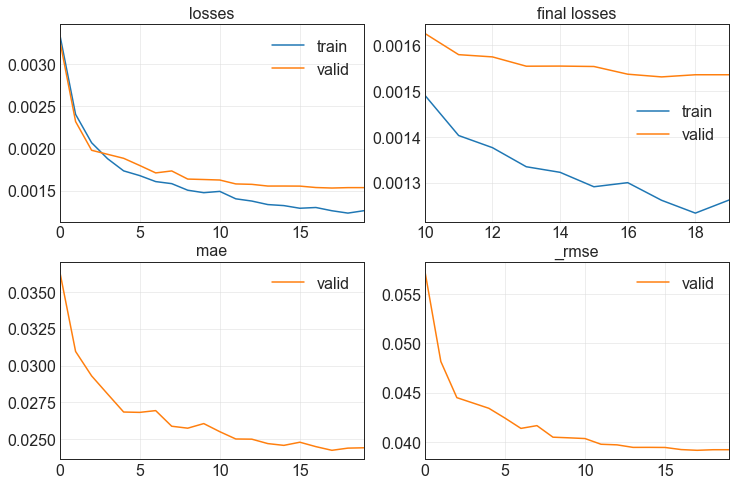

325.9459104537964                                                                                                      
[0.001262064790353179, 0.001535708666779101, 0.02442610263824463, 0.039188120514154434]                                
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 30%|███████████▋                           | 30/100 [2:38:12<5:51:45, 301.51s/trial, best loss: 0.0015323582338169217]

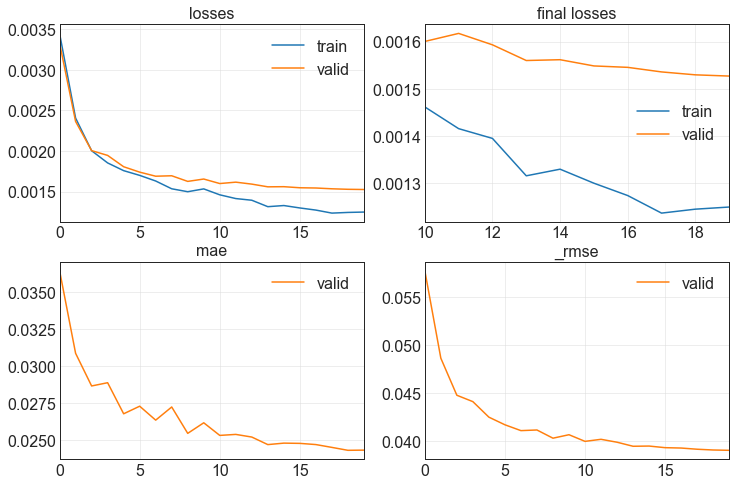

323.8998312950134                                                                                                      
[0.0012491432717069983, 0.0015269475989043713, 0.024330783635377884, 0.039076175540685654]                             
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 64, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 1, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 31%|████████████                           | 31/100 [2:43:41<5:56:05, 309.64s/trial, best loss: 0.0015269475989043713]

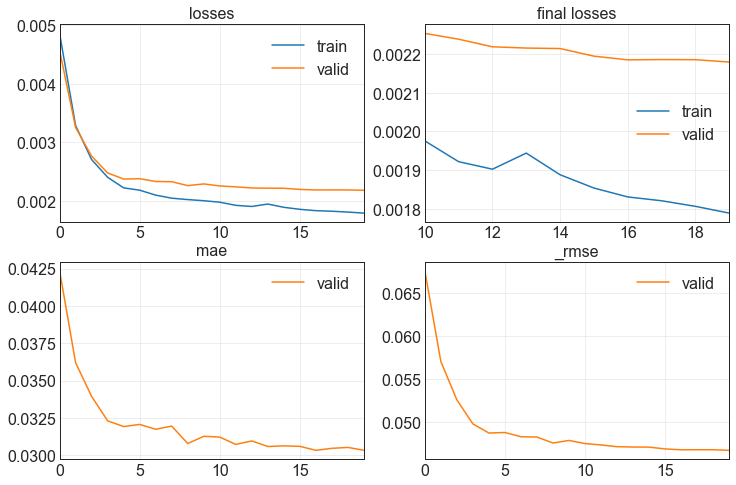

174.2864634990692                                                                                                      
[0.0017890871968120337, 0.002179394941776991, 0.03033880516886711, 0.046683985739946365]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 32%|████████████▍                          | 32/100 [2:46:40<5:06:30, 270.45s/trial, best loss: 0.0015269475989043713]

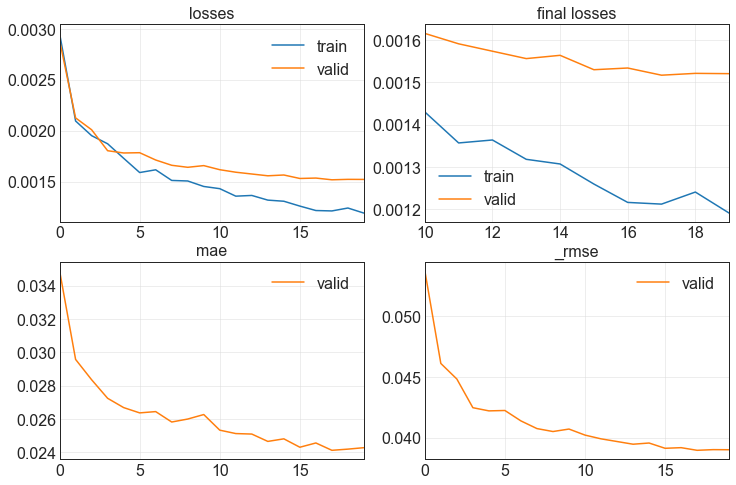

479.42502784729004                                                                                                     
[0.001190082635730505, 0.001520722871646285, 0.02427925355732441, 0.03899645432829857]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.01, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 33%|█████████████▏                          | 33/100 [2:54:44<6:13:40, 334.63s/trial, best loss: 0.001520722871646285]

No improvement since epoch 5: early stopping                                                                           
 33%|█████████████▏                          | 33/100 [2:58:58<6:13:40, 334.63s/trial, best loss: 0.001520722871646285]

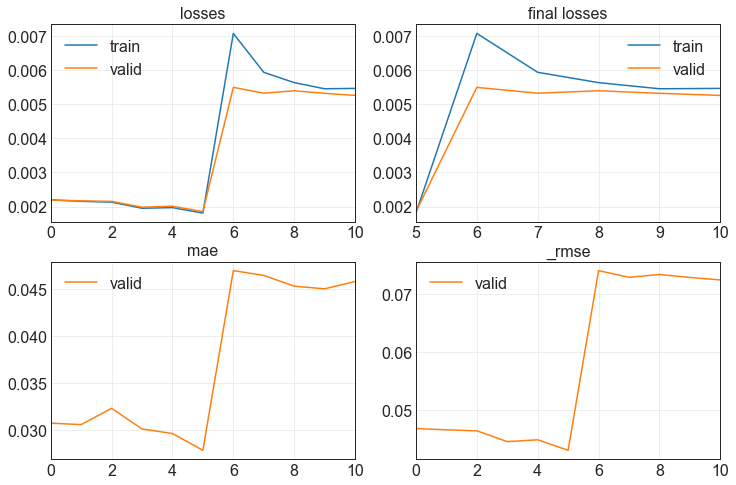

254.9183385372162                                                                                                      
[0.005465300753712654, 0.00525872316211462, 0.04576648771762848, 0.0725170448422432]                                   
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 64, 'epochs': 20, 'lr': 0.001, 'n_heads': 8, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 34%|█████████████▌                          | 34/100 [2:59:04<5:43:20, 312.13s/trial, best loss: 0.001520722871646285]

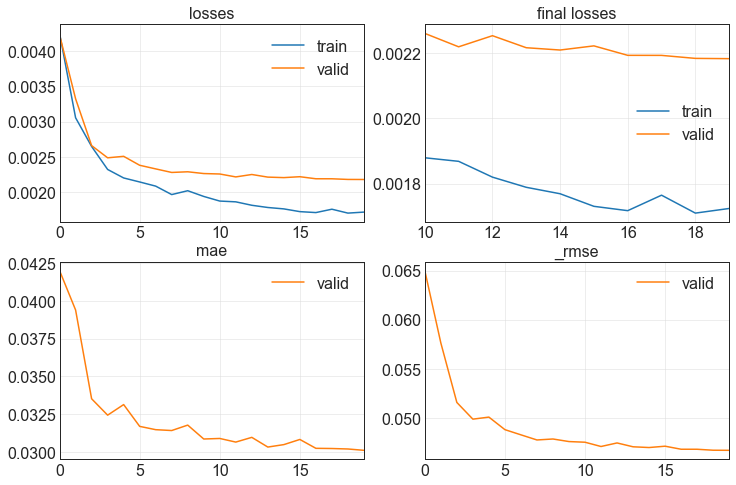

448.95658254623413                                                                                                     
[0.0017233998514711857, 0.00218348391354084, 0.030117982998490334, 0.04672776907682419]                                
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 35%|██████████████                          | 35/100 [3:06:37<6:24:07, 354.58s/trial, best loss: 0.001520722871646285]

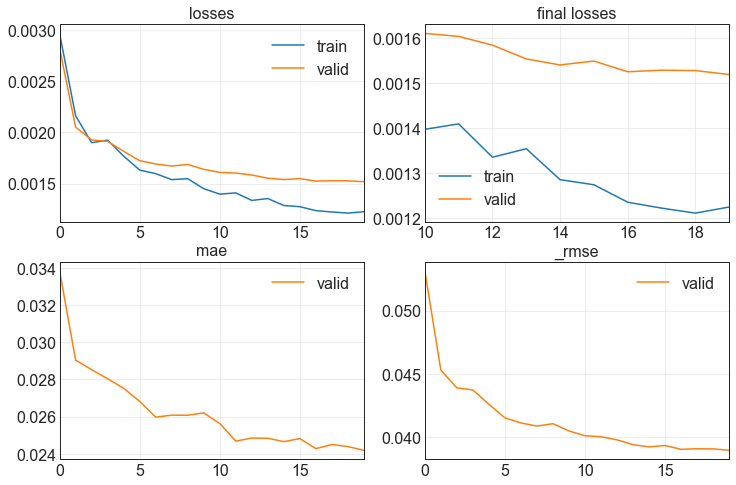

462.18309211730957                                                                                                     
[0.001224890467710793, 0.001518532633781433, 0.02419355697929859, 0.03896833956241608]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.1, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 36%|██████████████▍                         | 36/100 [3:14:24<6:54:08, 388.26s/trial, best loss: 0.001518532633781433]

No improvement since epoch 1: early stopping                                                                           
 36%|██████████████▍                         | 36/100 [3:17:16<6:54:08, 388.26s/trial, best loss: 0.001518532633781433]

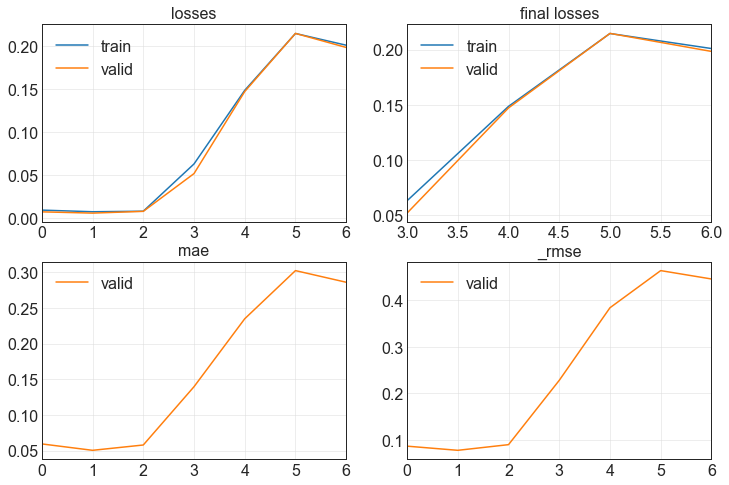

172.30615878105164                                                                                                     
[0.20100565254688263, 0.19838929176330566, 0.28590521216392517, 0.44540902972221375]                                   
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 100, 'lr': 0.001, 'n_heads': 16, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 37%|██████████████▊                         | 37/100 [3:17:21<5:41:06, 324.87s/trial, best loss: 0.001518532633781433]

No improvement since epoch 15: early stopping                                                                          
 37%|██████████████▊                         | 37/100 [3:25:59<5:41:06, 324.87s/trial, best loss: 0.001518532633781433]

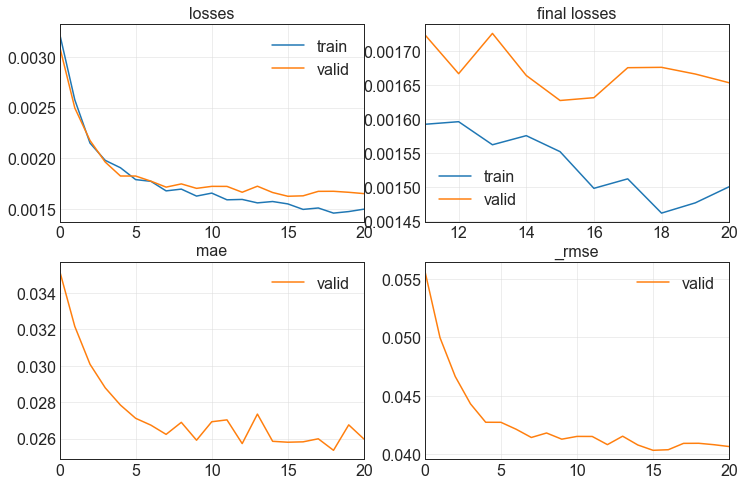

517.7684020996094                                                                                                      
[0.0015002513537183404, 0.0016534007154405117, 0.025971127673983574, 0.04066202789545059]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 64, 'epochs': 20, 'lr': 0.01, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 38%|███████████████▏                        | 38/100 [3:26:04<6:37:02, 384.23s/trial, best loss: 0.001518532633781433]

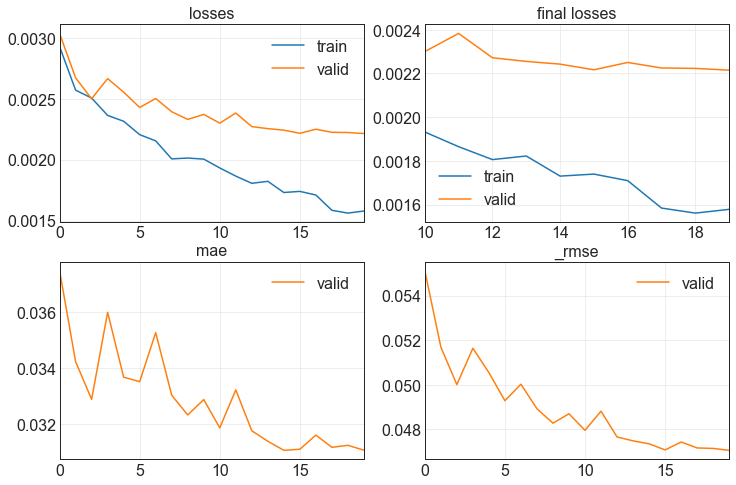

476.56381821632385                                                                                                     
[0.0015784658025950193, 0.002215237822383642, 0.031073477119207382, 0.04706631973385811]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 16, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 39%|███████████████▌                        | 39/100 [3:34:05<7:00:17, 413.41s/trial, best loss: 0.001518532633781433]

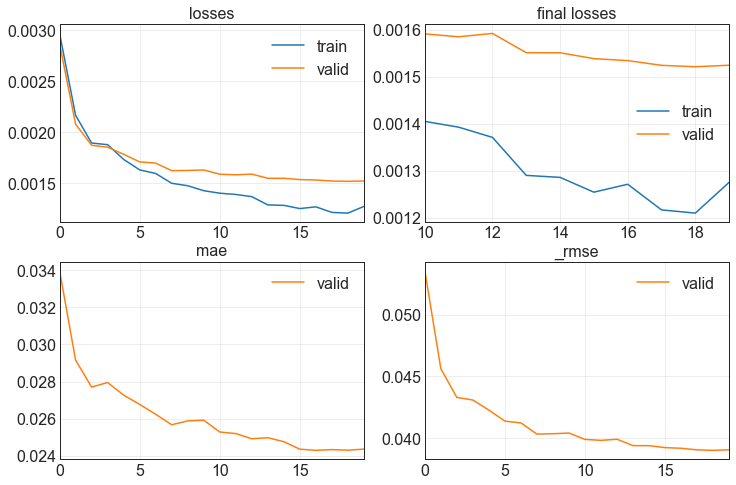

492.18906569480896                                                                                                     
[0.0012753058690577745, 0.0015242592198774219, 0.024350326508283615, 0.03904176503419876]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.1, 'n_heads': 8, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 10}
TST                                                                                                                    
 40%|████████████████                        | 40/100 [3:42:22<7:18:29, 438.49s/trial, best loss: 0.001518532633781433]

No improvement since epoch 0: early stopping                                                                           
 40%|████████████████                        | 40/100 [3:46:43<7:18:29, 438.49s/trial, best loss: 0.001518532633781433]

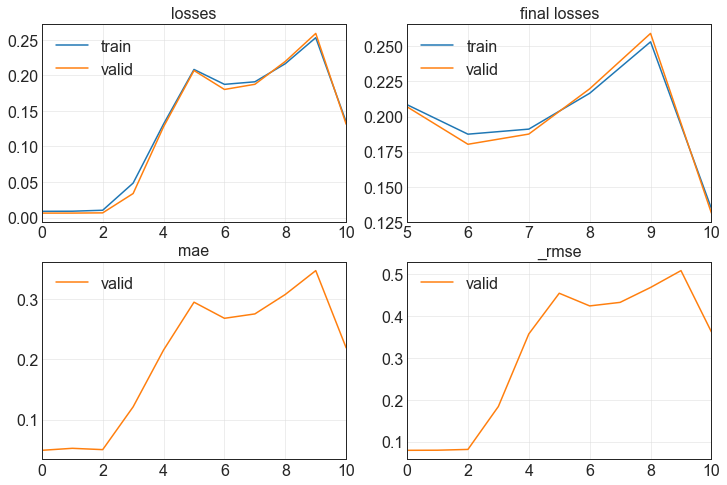

260.77832436561584                                                                                                     
[0.13452968001365662, 0.13128431141376495, 0.21880008280277252, 0.3623318374156952]                                    
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 100, 'lr': 0.001, 'n_heads': 32, 'n_layers': 4, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 41%|████████████████▍                       | 41/100 [3:46:48<6:20:11, 386.64s/trial, best loss: 0.001518532633781433]

No improvement since epoch 17: early stopping                                                                          
 41%|████████████████▍                       | 41/100 [4:01:50<6:20:11, 386.64s/trial, best loss: 0.001518532633781433]

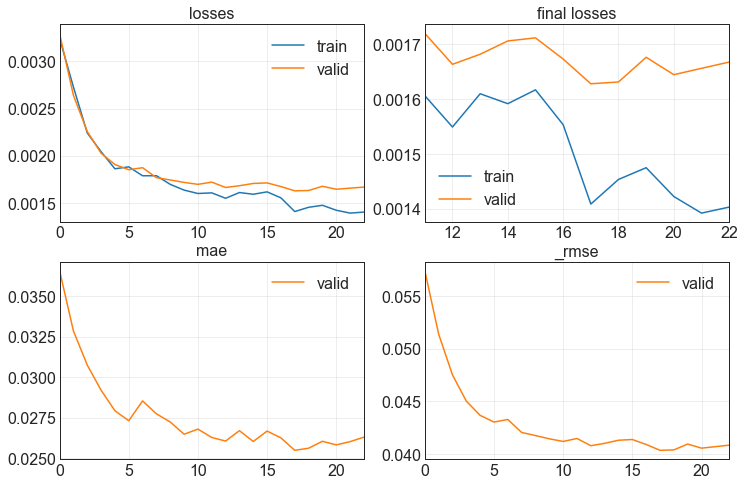

902.8755049705505                                                                                                      
[0.001402942813001573, 0.0016677281819283962, 0.026295213028788567, 0.04083782061934471]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 50, 'lr': 0.01, 'n_heads': 16, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 42%|████████████████▊                       | 42/100 [4:01:56<8:44:52, 542.97s/trial, best loss: 0.001518532633781433]

No improvement since epoch 17: early stopping                                                                          
 42%|████████████████▊                       | 42/100 [4:10:49<8:44:52, 542.97s/trial, best loss: 0.001518532633781433]

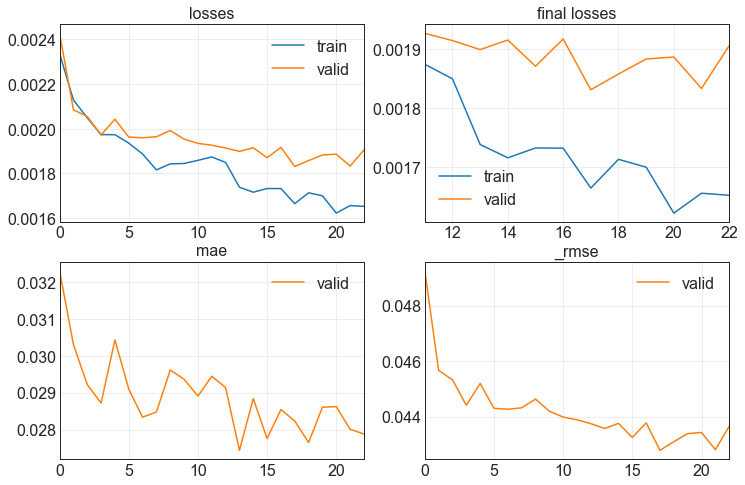

533.7358493804932                                                                                                      
[0.0016527606640011072, 0.0019053897121921182, 0.027877388522028923, 0.04365076869726181]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 10}
TST                                                                                                                    
 43%|█████████████████▏                      | 43/100 [4:10:54<8:34:33, 541.64s/trial, best loss: 0.001518532633781433]

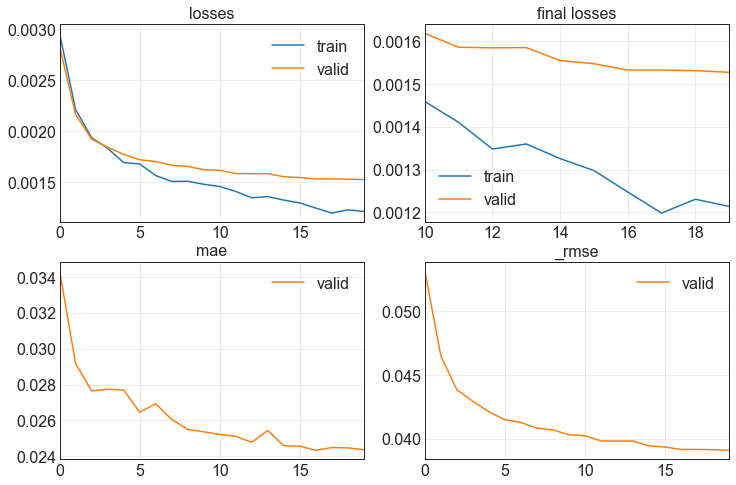

470.68737626075745                                                                                                     
[0.0012138769961893559, 0.001526751322671771, 0.02436552196741104, 0.03907367214560509]                                
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 64, 'epochs': 50, 'lr': 0.01, 'n_heads': 8, 'n_layers': 4, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 44%|█████████████████▌                      | 44/100 [4:18:50<8:07:00, 521.79s/trial, best loss: 0.001518532633781433]

No improvement since epoch 14: early stopping                                                                          
 44%|█████████████████▌                      | 44/100 [4:31:08<8:07:00, 521.79s/trial, best loss: 0.001518532633781433]

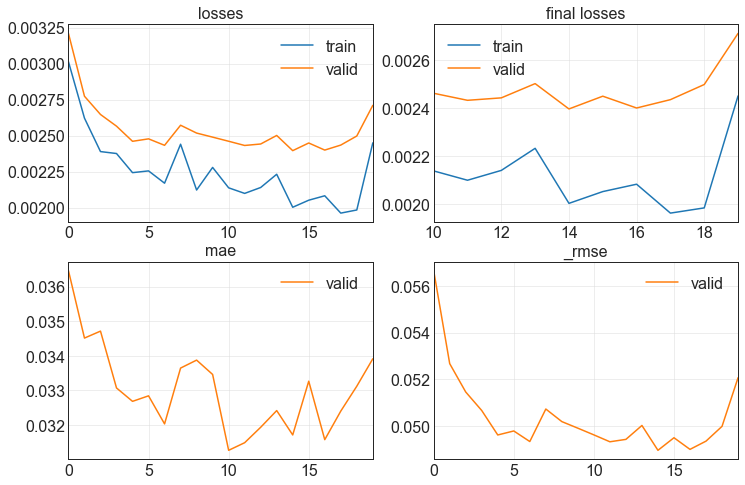

738.7432661056519                                                                                                      
[0.0024500000290572643, 0.002710328670218587, 0.03391124680638313, 0.052060820162296295]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 100, 'lr': 0.1, 'n_heads': 32, 'n_layers': 1, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 10}
TST                                                                                                                    
 45%|██████████████████                      | 45/100 [4:31:13<8:59:16, 588.30s/trial, best loss: 0.001518532633781433]

No improvement since epoch 3: early stopping                                                                           
 45%|██████████████████                      | 45/100 [4:34:56<8:59:16, 588.30s/trial, best loss: 0.001518532633781433]

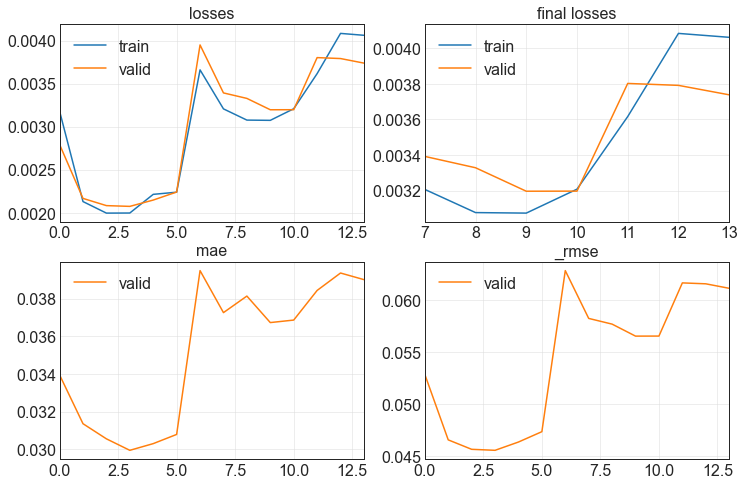

223.56114077568054                                                                                                     
[0.004061620682477951, 0.003738418687134981, 0.039013661444187164, 0.06114261597394943]                                
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 16, 'n_layers': 5, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 46%|██████████████████▍                     | 46/100 [4:35:01<7:12:16, 480.30s/trial, best loss: 0.001518532633781433]

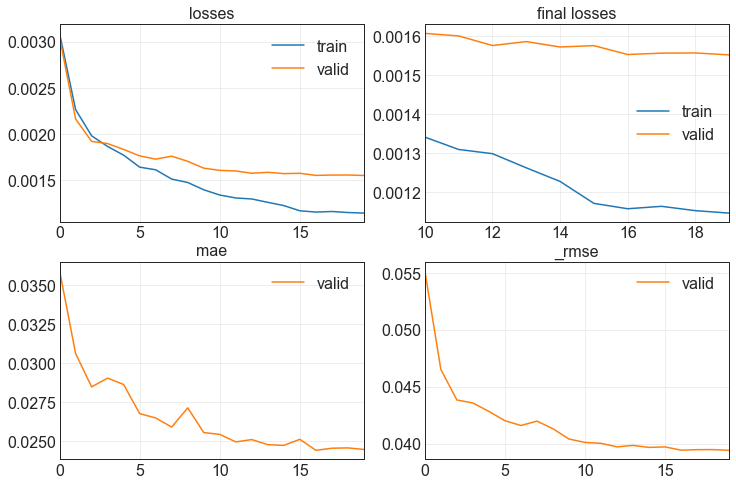

933.8717839717865                                                                                                      
[0.001146066002547741, 0.0015526622300967574, 0.024464134126901627, 0.03940384089946747]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 47%|██████████████████▊                     | 47/100 [4:50:40<9:05:42, 617.78s/trial, best loss: 0.001518532633781433]

No improvement since epoch 21: early stopping                                                                          
 47%|██████████████████▊                     | 47/100 [5:01:57<9:05:42, 617.78s/trial, best loss: 0.001518532633781433]

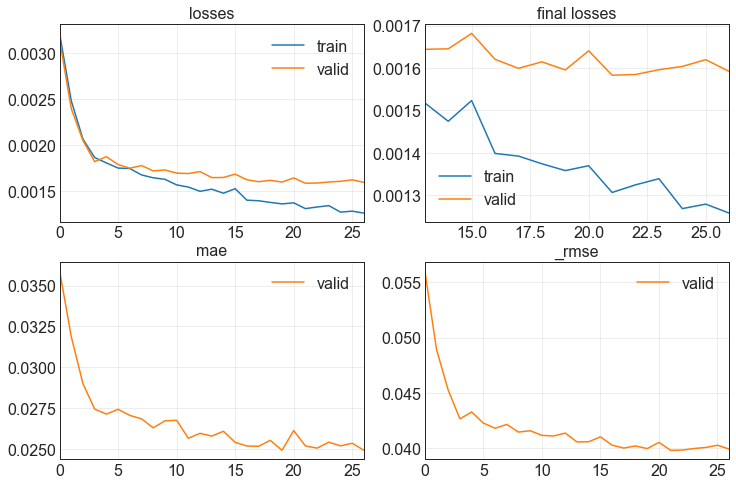

676.7288117408752                                                                                                      
[0.0012580957263708115, 0.0015919372672215104, 0.02493426576256752, 0.03989909589290619]                               
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 128, 'epochs': 20, 'lr': 0.1, 'n_heads': 8, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 10}
TST                                                                                                                    
 48%|███████████████████▏                    | 48/100 [5:02:02<9:12:03, 636.99s/trial, best loss: 0.001518532633781433]

No improvement since epoch 0: early stopping                                                                           
 48%|███████████████████▏                    | 48/100 [5:02:41<9:12:03, 636.99s/trial, best loss: 0.001518532633781433]

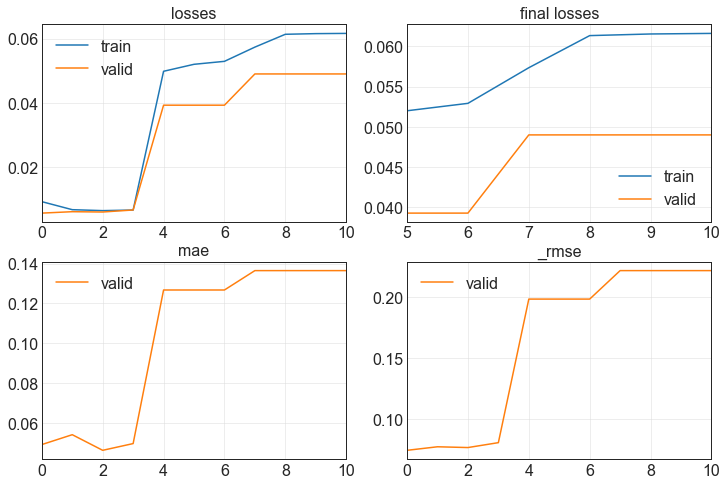

39.31927251815796                                                                                                      
[0.061622459441423416, 0.04898207262158394, 0.13649781048297882, 0.22131894528865814]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 100, 'lr': 0.01, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 49%|███████████████████▌                    | 49/100 [5:02:46<6:30:15, 459.13s/trial, best loss: 0.001518532633781433]

No improvement since epoch 8: early stopping                                                                           
 49%|███████████████████▌                    | 49/100 [5:05:09<6:30:15, 459.13s/trial, best loss: 0.001518532633781433]

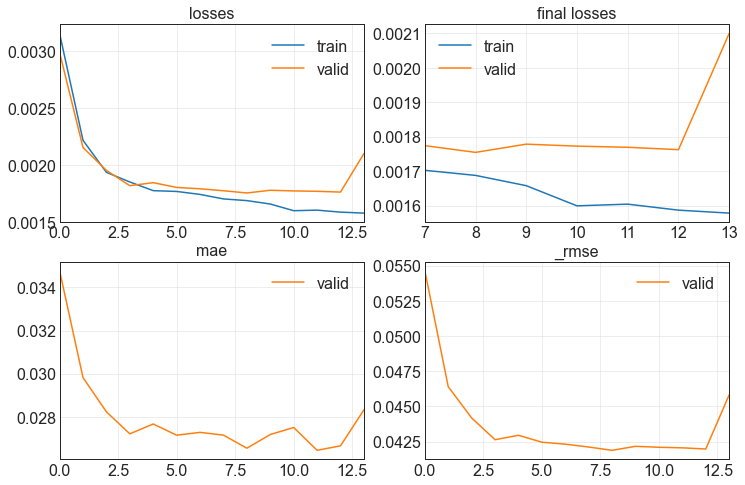

143.7892689704895                                                                                                      
[0.0015782294794917107, 0.002099880250170827, 0.02832251600921154, 0.045824453234672546]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 64, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 1, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 50%|████████████████████                    | 50/100 [5:05:15<5:04:58, 365.98s/trial, best loss: 0.001518532633781433]

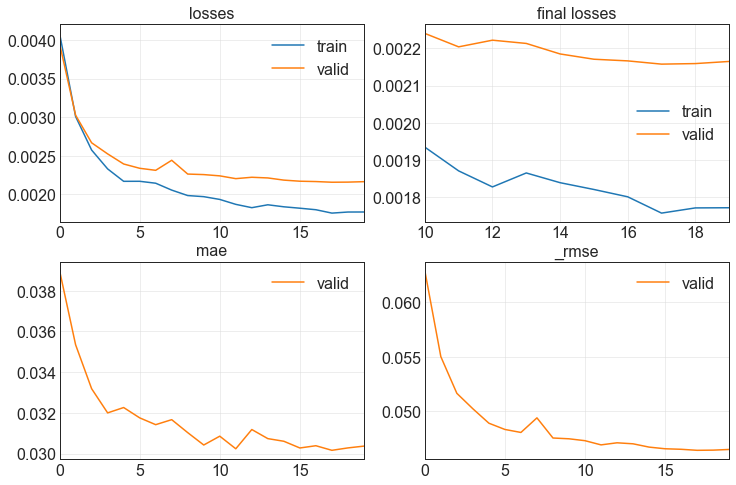

331.81736040115356                                                                                                     
[0.0017721329350024462, 0.0021648905239999294, 0.030364595353603363, 0.04652838781476021]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 32, 'n_layers': 5, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 10}
TST                                                                                                                    
 51%|████████████████████▍                   | 51/100 [5:10:52<4:51:42, 357.19s/trial, best loss: 0.001518532633781433]

No improvement since epoch 19: early stopping                                                                          
 51%|████████████████████▍                   | 51/100 [5:34:15<4:51:42, 357.19s/trial, best loss: 0.001518532633781433]

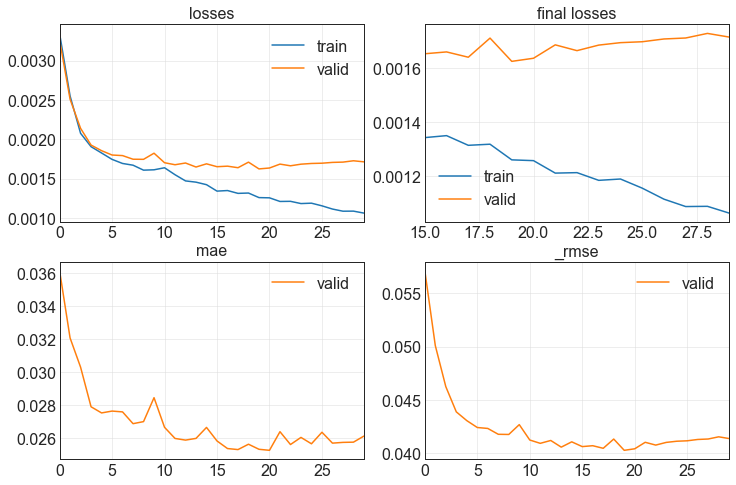

1404.0819864273071                                                                                                     
[0.001061872811987996, 0.001713703153654933, 0.02612360380589962, 0.04139689728617668]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 128, 'epochs': 20, 'lr': 0.1, 'n_heads': 8, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 52%|████████████████████▊                   | 52/100 [5:34:21<8:58:13, 672.78s/trial, best loss: 0.001518532633781433]

No improvement since epoch 2: early stopping                                                                           
 52%|████████████████████▊                   | 52/100 [5:34:47<8:58:13, 672.78s/trial, best loss: 0.001518532633781433]

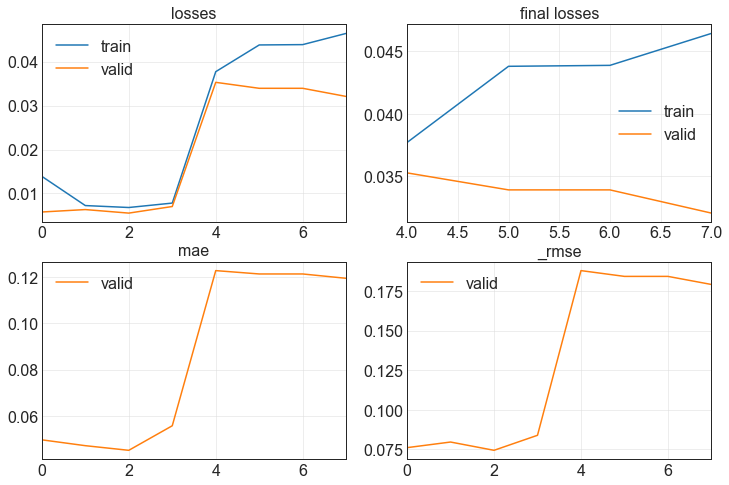

27.208271503448486                                                                                                     
[0.04641339182853699, 0.03207214176654816, 0.11955949664115906, 0.17908698320388794]                                   
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 100, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 53%|█████████████████████▏                  | 53/100 [5:34:52<6:16:25, 480.55s/trial, best loss: 0.001518532633781433]

No improvement since epoch 32: early stopping                                                                          
 53%|█████████████████████▏                  | 53/100 [5:38:48<6:16:25, 480.55s/trial, best loss: 0.001518532633781433]

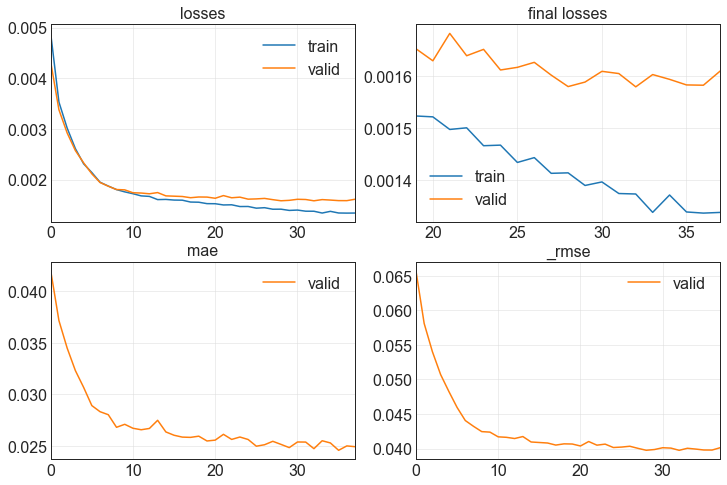

235.95053505897522                                                                                                     
[0.0013378638541325927, 0.0016102056251838803, 0.02494659833610058, 0.04012736678123474]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.01, 'n_heads': 16, 'n_layers': 5, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 10}
TST                                                                                                                    
 54%|█████████████████████▌                  | 54/100 [5:38:53<5:13:15, 408.60s/trial, best loss: 0.001518532633781433]

No improvement since epoch 4: early stopping                                                                           
 54%|█████████████████████▌                  | 54/100 [5:50:24<5:13:15, 408.60s/trial, best loss: 0.001518532633781433]

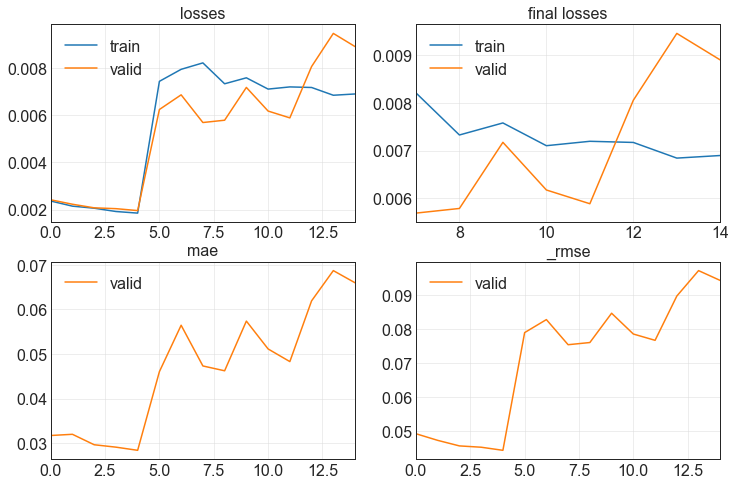

691.1843123435974                                                                                                      
[0.006895342376083136, 0.008899133652448654, 0.0659852847456932, 0.09433522820472717]                                  
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 128, 'epochs': 50, 'lr': 0.001, 'n_heads': 32, 'n_layers': 4, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 55%|██████████████████████                  | 55/100 [5:50:29<6:11:06, 494.80s/trial, best loss: 0.001518532633781433]

No improvement since epoch 44: early stopping                                                                          
 55%|██████████████████████                  | 55/100 [5:55:03<6:11:06, 494.80s/trial, best loss: 0.001518532633781433]

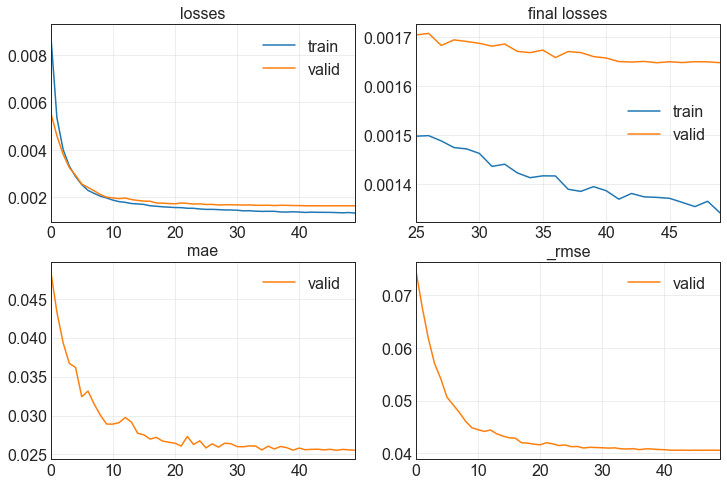

274.07062888145447                                                                                                     
[0.0013409423409029841, 0.0016473056748509407, 0.025539733469486237, 0.04058701545000076]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 1, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 56%|██████████████████████▍                 | 56/100 [5:55:08<5:15:20, 430.02s/trial, best loss: 0.001518532633781433]

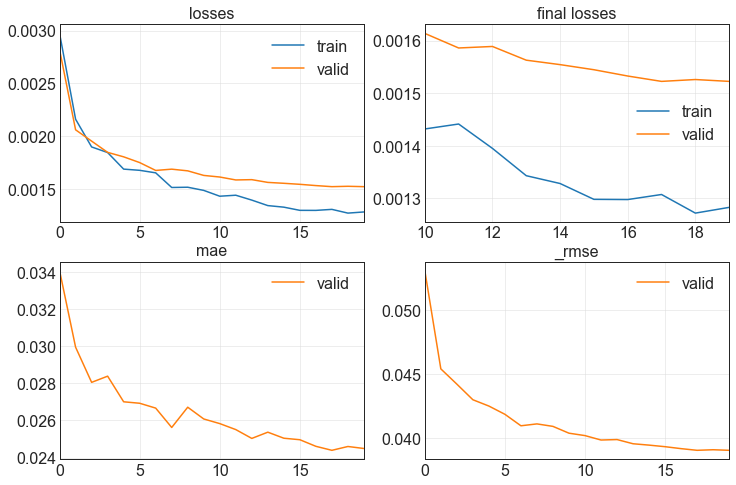

327.6304421424866                                                                                                      
[0.001282782875932753, 0.001522470498457551, 0.024487381801009178, 0.03901885077357292]                                
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 64, 'epochs': 100, 'lr': 0.1, 'n_heads': 8, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 57%|██████████████████████▊                 | 57/100 [6:00:41<4:47:17, 400.87s/trial, best loss: 0.001518532633781433]

No improvement since epoch 6: early stopping                                                                           
 57%|██████████████████████▊                 | 57/100 [6:01:57<4:47:17, 400.87s/trial, best loss: 0.001518532633781433]

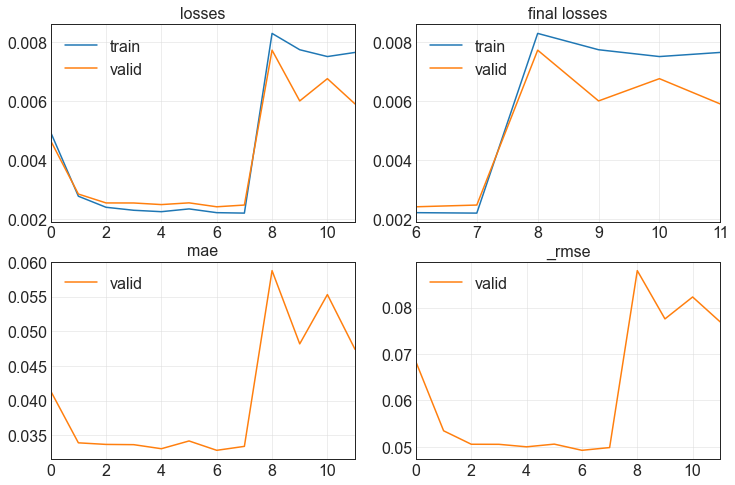

76.23282051086426                                                                                                      
[0.007660276722162962, 0.005911975167691708, 0.04738578572869301, 0.07688936591148376]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 10}
TST                                                                                                                    
 58%|███████████████████████▏                | 58/100 [6:02:02<3:33:26, 304.92s/trial, best loss: 0.001518532633781433]

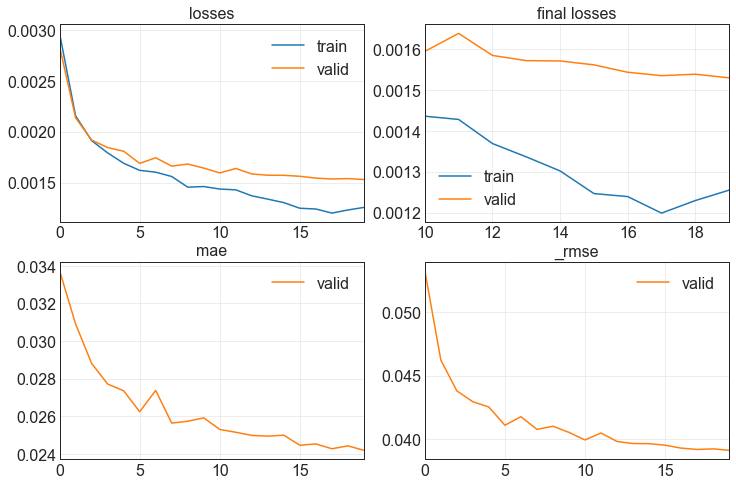

478.8170156478882                                                                                                      
[0.0012549043167382479, 0.0015294390032067895, 0.02419147826731205, 0.0391080416738987]                                
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 5, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 59%|███████████████████████▌                | 59/100 [6:10:06<4:04:58, 358.51s/trial, best loss: 0.001518532633781433]

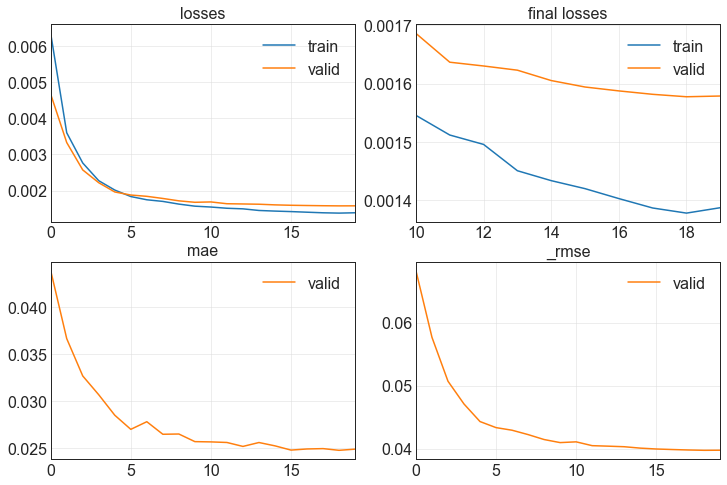

135.27183604240417                                                                                                     
[0.0013871208066120744, 0.0015788162127137184, 0.024895455688238144, 0.03973431885242462]                              
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 128, 'epochs': 50, 'lr': 0.01, 'n_heads': 16, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 60%|████████████████████████                | 60/100 [6:12:26<3:15:19, 292.99s/trial, best loss: 0.001518532633781433]

No improvement since epoch 31: early stopping                                                                          
 60%|████████████████████████                | 60/100 [6:16:26<3:15:19, 292.99s/trial, best loss: 0.001518532633781433]

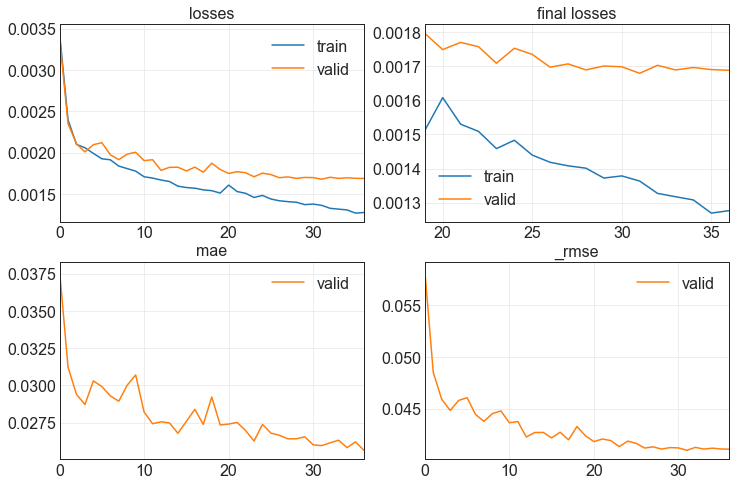

240.44144010543823                                                                                                     
[0.0012767210137099028, 0.0016882470808923244, 0.025650007650256157, 0.0410882830619812]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 4, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 61%|████████████████████████▍               | 61/100 [6:16:31<3:01:07, 278.65s/trial, best loss: 0.001518532633781433]

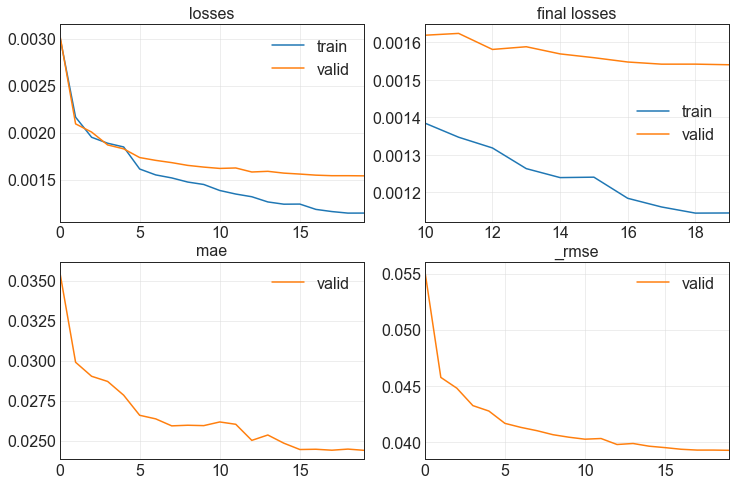

790.4182786941528                                                                                                      
[0.0011444902047514915, 0.0015402354765683413, 0.02439255639910698, 0.039245836436748505]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 64, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 1, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 10}
TST                                                                                                                    
 62%|████████████████████████▊               | 62/100 [6:29:46<4:34:40, 433.69s/trial, best loss: 0.001518532633781433]

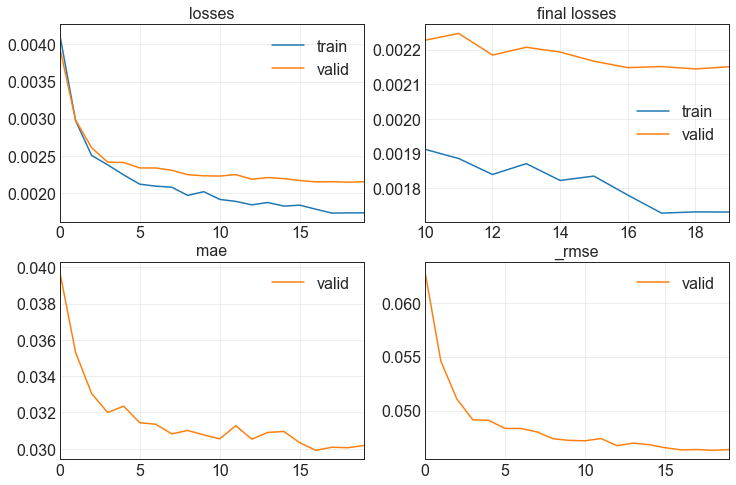

325.2812497615814                                                                                                      
[0.0017313191201537848, 0.002150805201381445, 0.030182747170329094, 0.04637676849961281]                               
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 256, 'epochs': 100, 'lr': 0.1, 'n_heads': 8, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 63%|█████████████████████████▏              | 63/100 [6:35:17<4:08:16, 402.61s/trial, best loss: 0.001518532633781433]

No improvement since epoch 4: early stopping                                                                           
 63%|█████████████████████████▏              | 63/100 [6:35:52<4:08:16, 402.61s/trial, best loss: 0.001518532633781433]

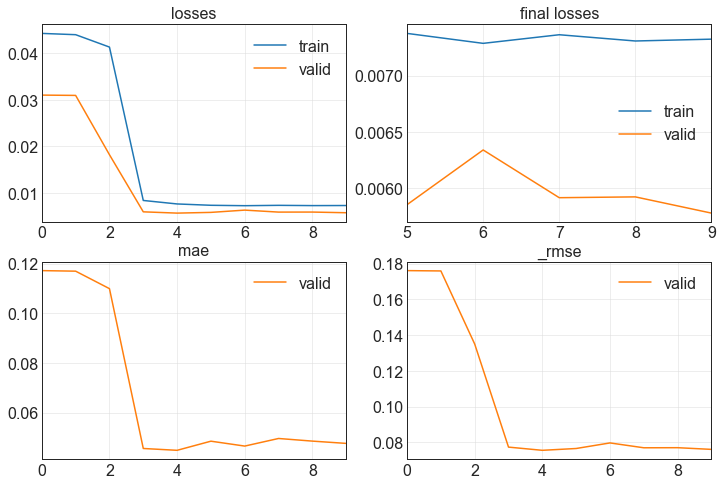

35.6017861366272                                                                                                       
[0.007325287908315659, 0.005776967853307724, 0.04765581712126732, 0.07600636035203934]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 64%|█████████████████████████▌              | 64/100 [6:35:57<2:56:24, 294.01s/trial, best loss: 0.001518532633781433]

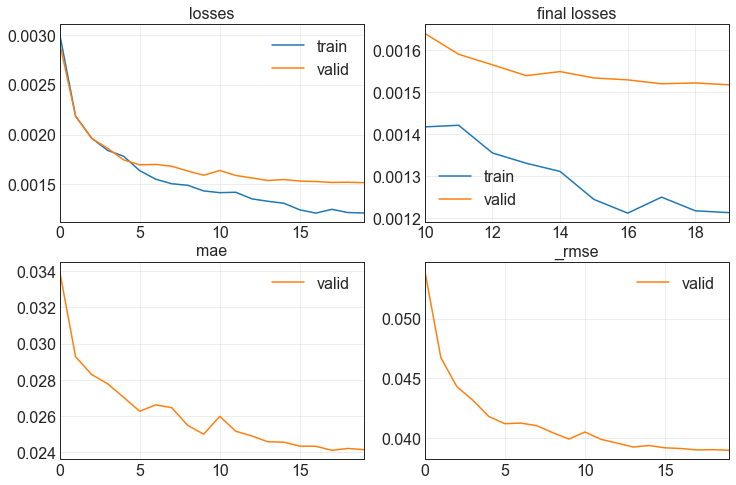

487.1068639755249                                                                                                      
[0.0012133881682530046, 0.0015172121347859502, 0.024149512872099876, 0.038951411843299866]                             
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 65%|█████████████████████████▎             | 65/100 [6:44:09<3:26:08, 353.38s/trial, best loss: 0.0015172121347859502]

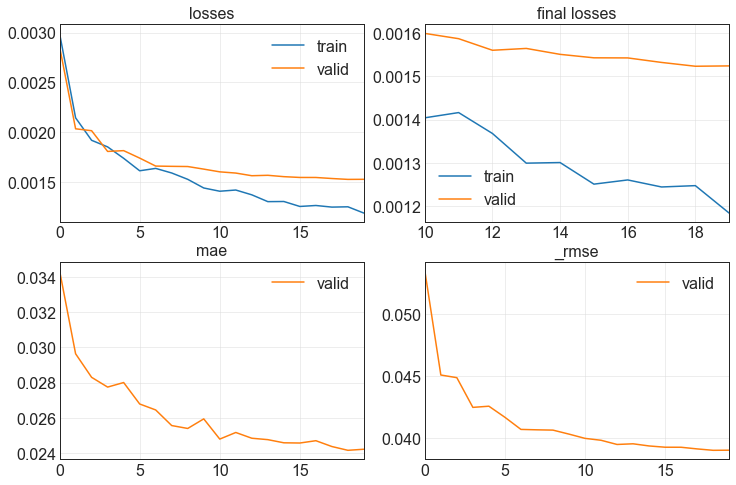

490.08857679367065                                                                                                     
[0.0011842234525829554, 0.0015242756344377995, 0.024222005158662796, 0.039041969925165176]                             
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 66%|█████████████████████████▋             | 66/100 [6:52:24<3:44:18, 395.85s/trial, best loss: 0.0015172121347859502]

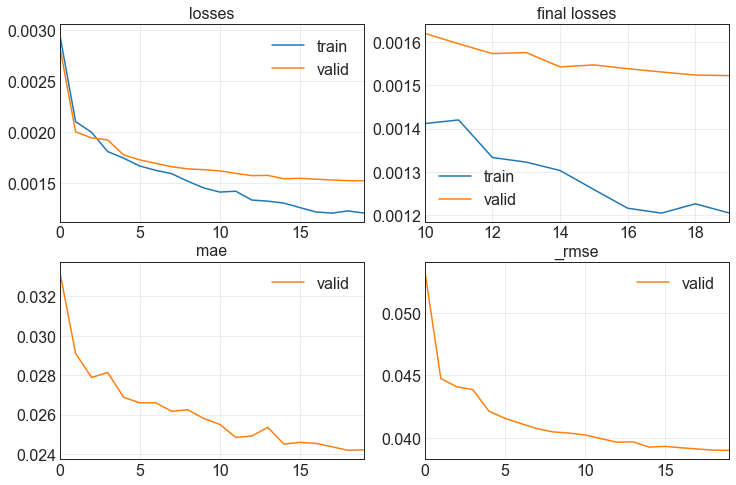

473.48021626472473                                                                                                     
[0.0012052390957251191, 0.0015222877264022827, 0.02421926148235798, 0.03901650011539459]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 67%|██████████████████████████▏            | 67/100 [7:00:22<3:51:19, 420.60s/trial, best loss: 0.0015172121347859502]

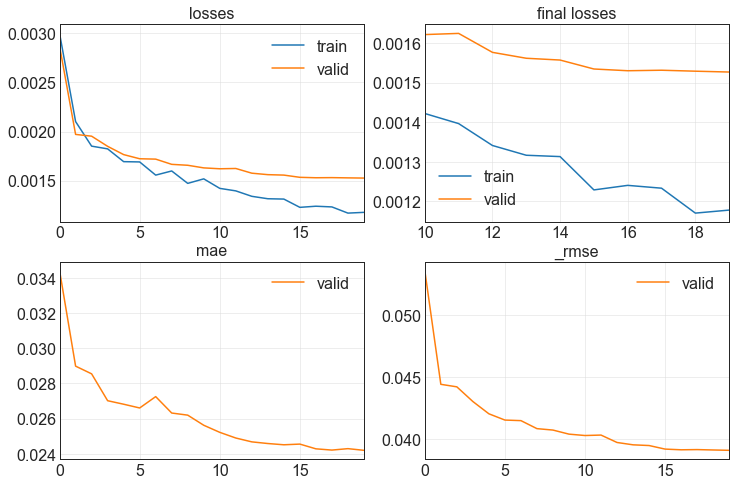

486.7352910041809                                                                                                      
[0.001177862985059619, 0.0015267154667526484, 0.024204712361097336, 0.03907319903373718]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 68%|██████████████████████████▌            | 68/100 [7:08:34<3:55:39, 441.87s/trial, best loss: 0.0015172121347859502]

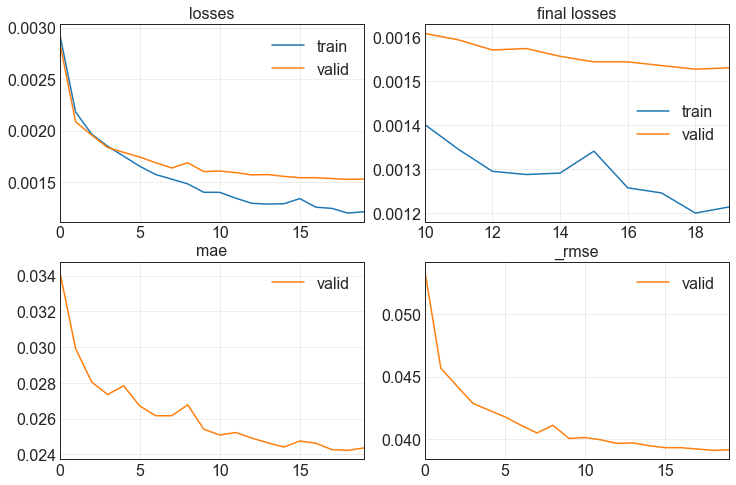

489.4705786705017                                                                                                      
[0.0012137049343436956, 0.0015299308579415083, 0.024362336844205856, 0.0391143262386322]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 69%|██████████████████████████▉            | 69/100 [7:16:48<3:56:26, 457.64s/trial, best loss: 0.0015172121347859502]

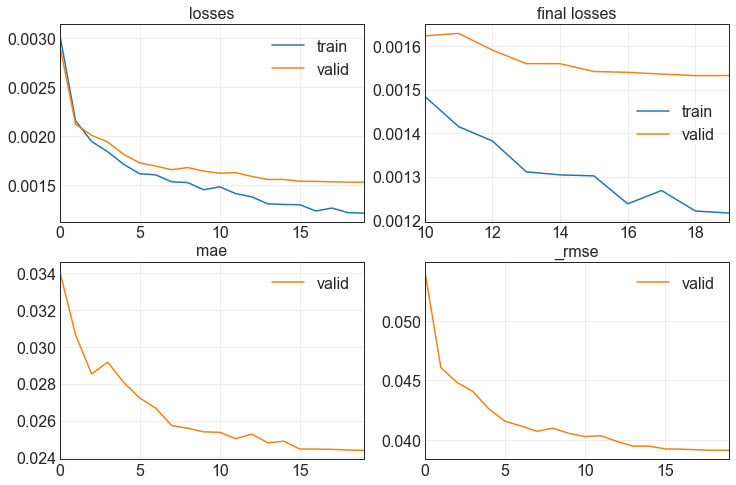

487.0750961303711                                                                                                      
[0.0012158118188381195, 0.0015322776744142175, 0.024384649470448494, 0.03914431855082512]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 70%|███████████████████████████▎           | 70/100 [7:25:00<3:53:59, 467.97s/trial, best loss: 0.0015172121347859502]

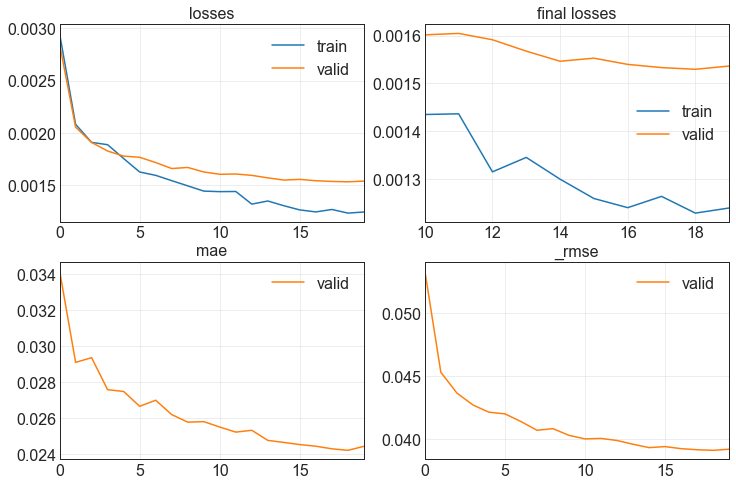

484.5798382759094                                                                                                      
[0.0012399445986375213, 0.0015362665290012956, 0.024439146742224693, 0.039195235818624496]                             
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 71%|███████████████████████████▋           | 71/100 [7:33:10<3:49:17, 474.41s/trial, best loss: 0.0015172121347859502]

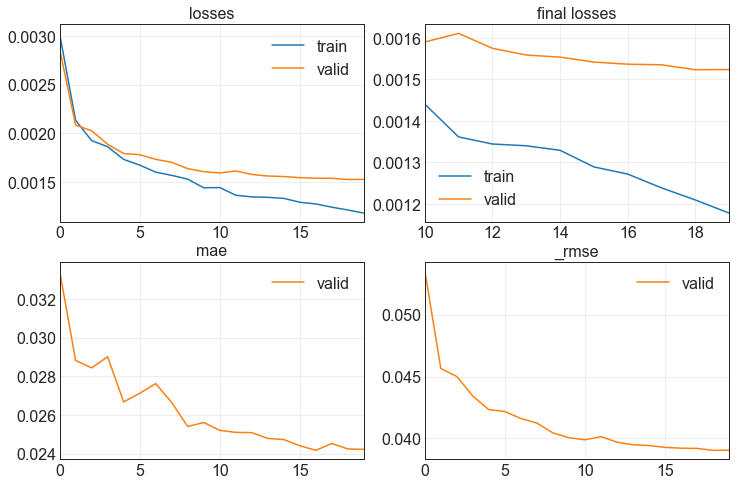

492.80091094970703                                                                                                     
[0.0011773481965065002, 0.0015238902997225523, 0.02422010712325573, 0.03903703764081001]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 72%|████████████████████████████           | 72/100 [7:41:28<3:44:38, 481.38s/trial, best loss: 0.0015172121347859502]

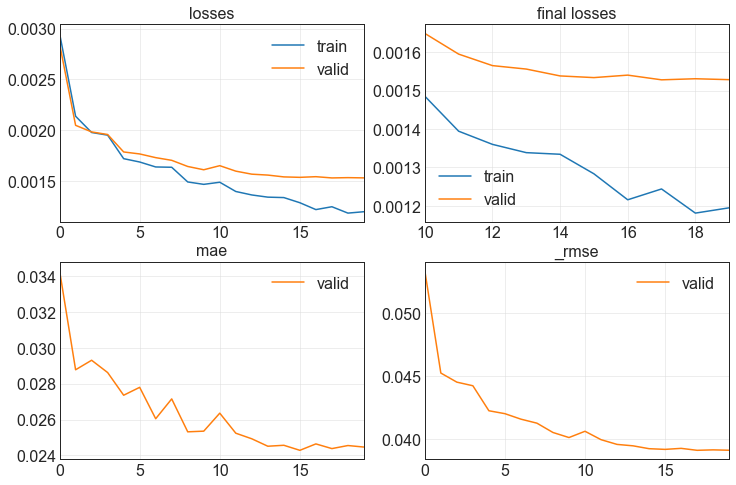

488.8738272190094                                                                                                      
[0.0011948042083531618, 0.0015283901011571288, 0.024464763700962067, 0.039094626903533936]                             
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 5, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 73%|████████████████████████████▍          | 73/100 [7:49:42<3:38:20, 485.19s/trial, best loss: 0.0015172121347859502]

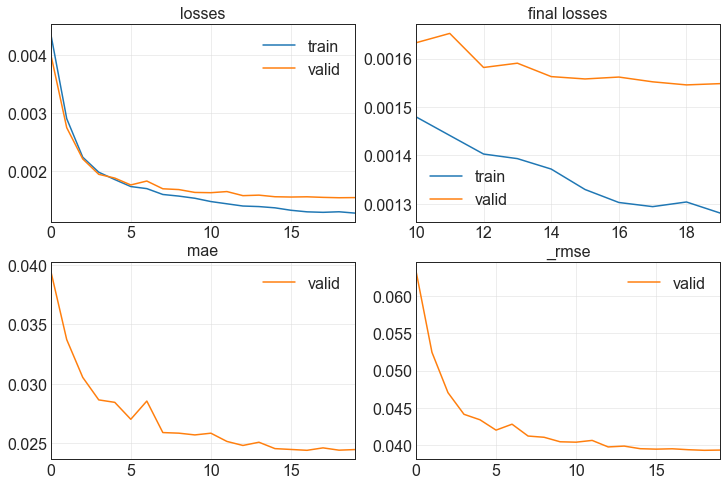

242.8255934715271                                                                                                      
[0.0012807691236957908, 0.0015481492737308145, 0.024483323097229004, 0.03934652730822563]                              
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 74%|████████████████████████████▊          | 74/100 [7:53:49<2:59:24, 414.03s/trial, best loss: 0.0015172121347859502]

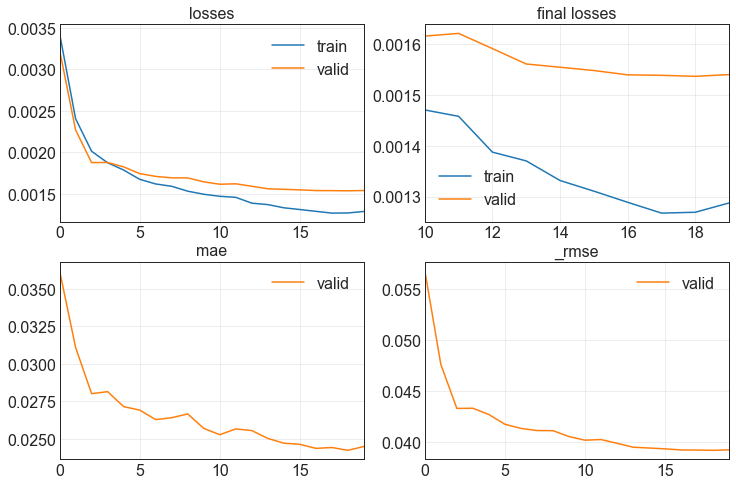

248.3122706413269                                                                                                      
[0.0012877524131909013, 0.0015396998496726155, 0.024498865008354187, 0.039239004254341125]                             
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.01, 'n_heads': 32, 'n_layers': 1, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 75%|█████████████████████████████▎         | 75/100 [7:58:03<2:32:23, 365.73s/trial, best loss: 0.0015172121347859502]

No improvement since epoch 0: early stopping                                                                           
 75%|█████████████████████████████▎         | 75/100 [7:59:41<2:32:23, 365.73s/trial, best loss: 0.0015172121347859502]

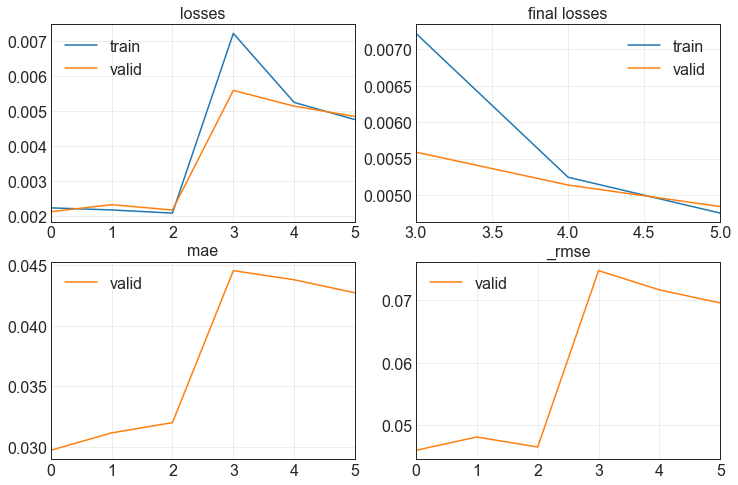

98.40412831306458                                                                                                      
[0.004751632455736399, 0.004841758869588375, 0.04271426424384117, 0.0695827528834343]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 64, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 76%|█████████████████████████████▋         | 76/100 [7:59:46<1:54:51, 287.15s/trial, best loss: 0.0015172121347859502]

No improvement since epoch 20: early stopping                                                                          
 76%|█████████████████████████████▋         | 76/100 [8:16:05<1:54:51, 287.15s/trial, best loss: 0.0015172121347859502]

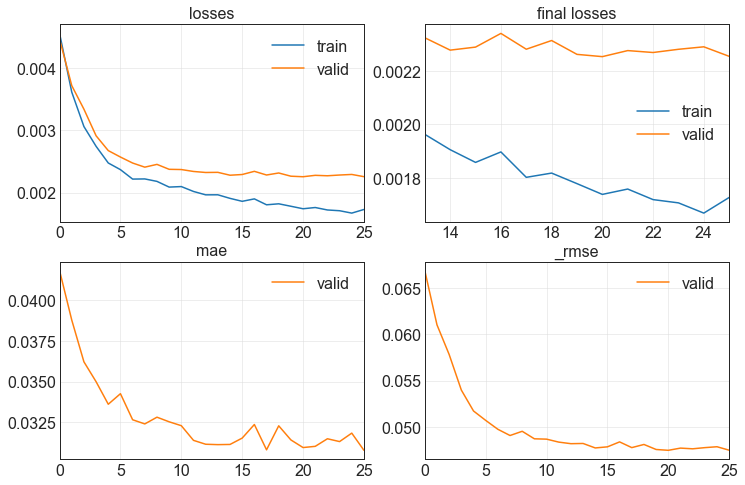

979.1345953941345                                                                                                      
[0.0017266827635467052, 0.0022552250884473324, 0.03078240156173706, 0.04748921096324921]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 77%|██████████████████████████████         | 77/100 [8:16:10<3:10:11, 496.16s/trial, best loss: 0.0015172121347859502]

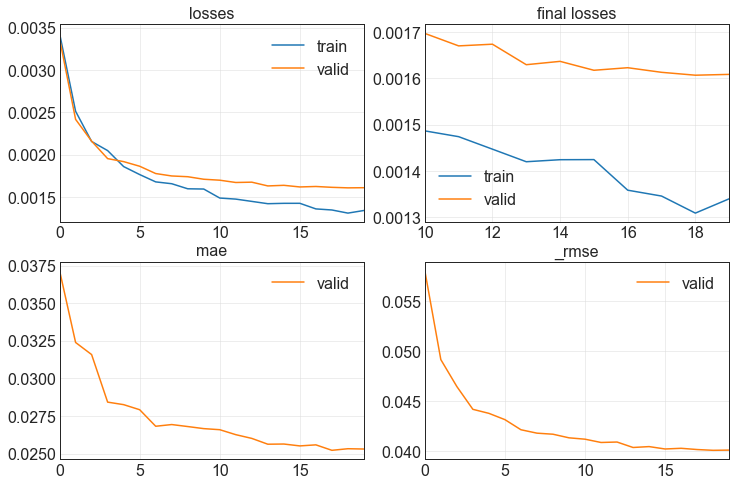

480.3662269115448                                                                                                      
[0.0013397963484749198, 0.001608771737664938, 0.02529788576066494, 0.040109507739543915]                               
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.1, 'n_heads': 8, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 78%|██████████████████████████████▍        | 78/100 [8:24:15<3:00:43, 492.89s/trial, best loss: 0.0015172121347859502]

No improvement since epoch 0: early stopping                                                                           
 78%|██████████████████████████████▍        | 78/100 [8:25:27<3:00:43, 492.89s/trial, best loss: 0.0015172121347859502]

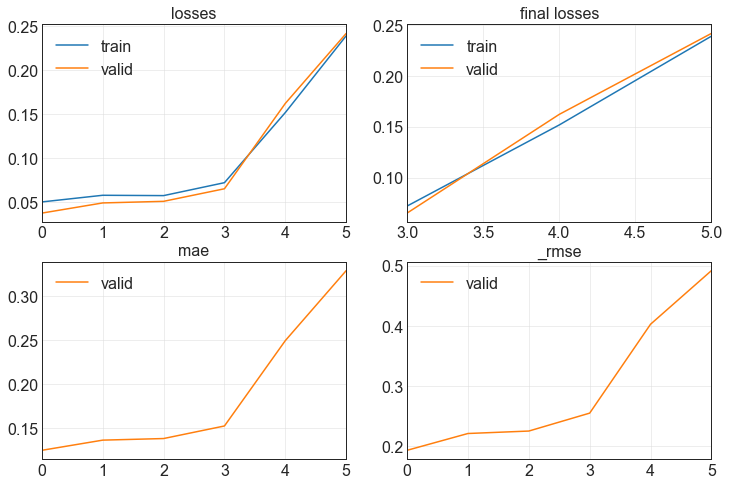

72.51053023338318                                                                                                      
[0.23894493281841278, 0.24166277050971985, 0.32917866110801697, 0.4915921092033386]                                    
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 100, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 10}
TST                                                                                                                    
 79%|██████████████████████████████▊        | 79/100 [8:25:33<2:08:52, 368.23s/trial, best loss: 0.0015172121347859502]

No improvement since epoch 26: early stopping                                                                          
 79%|██████████████████████████████▊        | 79/100 [8:45:03<2:08:52, 368.23s/trial, best loss: 0.0015172121347859502]

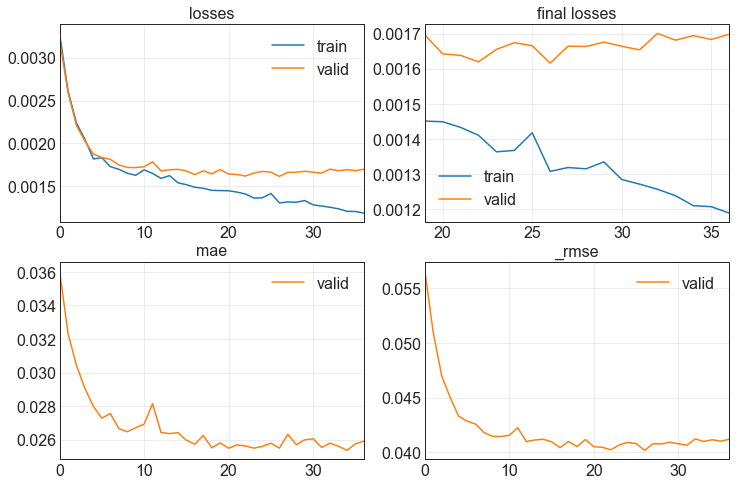

1170.9238045215607                                                                                                     
[0.0011877627111971378, 0.0016983445966616273, 0.025910791009664536, 0.041210975497961044]                             
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 80%|███████████████████████████████▏       | 80/100 [8:45:08<3:23:29, 610.46s/trial, best loss: 0.0015172121347859502]

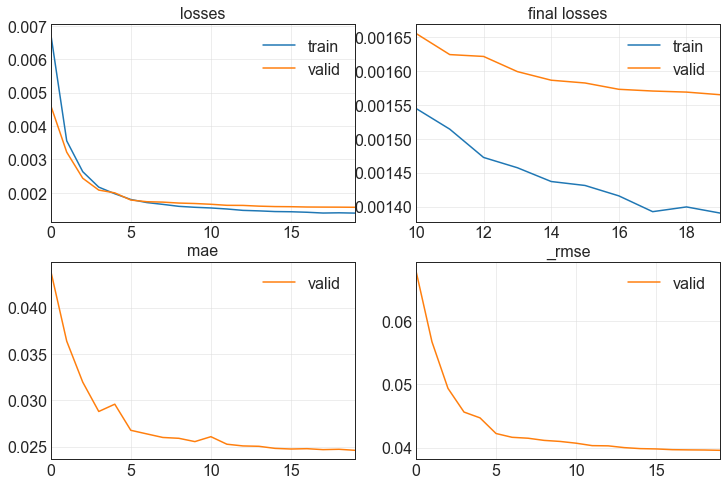

71.53952598571777                                                                                                      
[0.001390468911267817, 0.001564885606057942, 0.02460065484046936, 0.039558641612529755]                                
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 64, 'epochs': 20, 'lr': 0.01, 'n_heads': 16, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 81%|███████████████████████████████▌       | 81/100 [8:46:25<2:22:34, 450.25s/trial, best loss: 0.0015172121347859502]

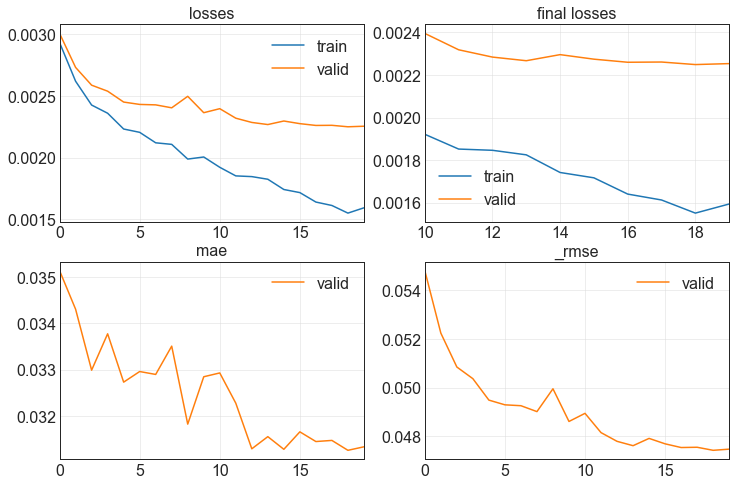

472.9668073654175                                                                                                      
[0.001593223656527698, 0.0022534995805472136, 0.03132852539420128, 0.0474710613489151]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 32, 'n_layers': 5, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 82%|███████████████████████████████▉       | 82/100 [8:54:22<2:17:32, 458.48s/trial, best loss: 0.0015172121347859502]

No improvement since epoch 31: early stopping                                                                          
 82%|███████████████████████████████▉       | 82/100 [9:01:47<2:17:32, 458.48s/trial, best loss: 0.0015172121347859502]

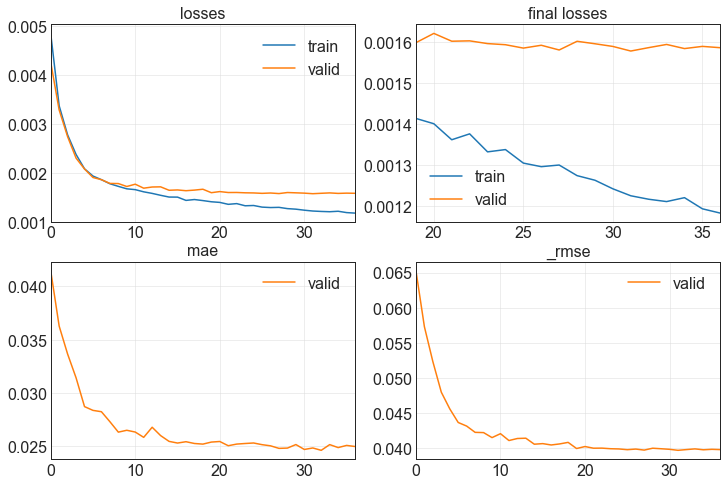

445.426305770874                                                                                                       
[0.0011827826965600252, 0.0015866186004132032, 0.024989690631628036, 0.039832379668951035]                             
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 4, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 83%|████████████████████████████████▎      | 83/100 [9:01:53<2:09:12, 456.02s/trial, best loss: 0.0015172121347859502]

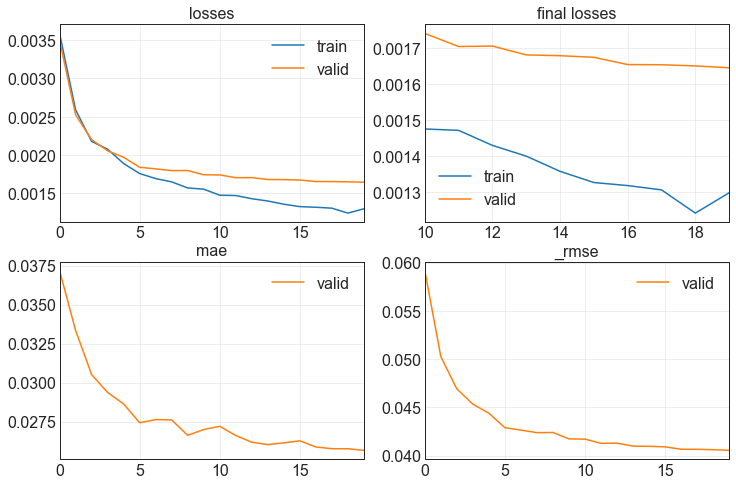

769.6006355285645                                                                                                      
[0.0012976240832358599, 0.0016445463988929987, 0.025654450058937073, 0.040553018450737]                                
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 100, 'lr': 0.1, 'n_heads': 8, 'n_layers': 1, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 10}
TST                                                                                                                    
 84%|████████████████████████████████▊      | 84/100 [9:14:47<2:27:04, 551.56s/trial, best loss: 0.0015172121347859502]

No improvement since epoch 12: early stopping                                                                          
 84%|████████████████████████████████▊      | 84/100 [9:17:54<2:27:04, 551.56s/trial, best loss: 0.0015172121347859502]

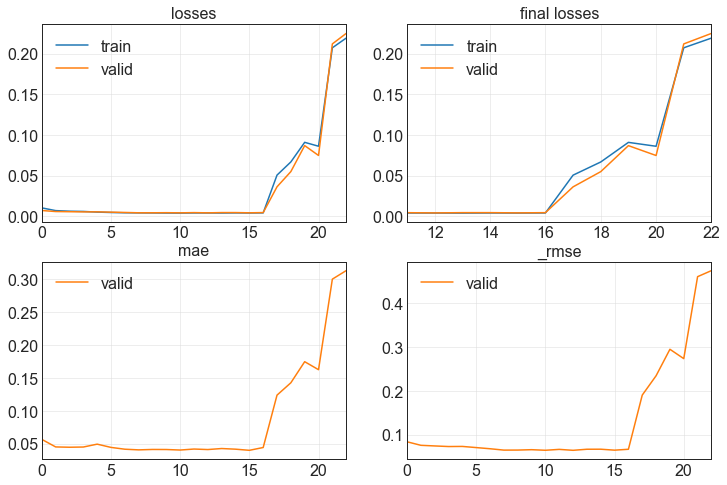

187.44275498390198                                                                                                     
[0.21917709708213806, 0.2249479740858078, 0.31246381998062134, 0.474286824464798]                                      
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 85%|█████████████████████████████████▏     | 85/100 [9:17:59<1:50:56, 443.76s/trial, best loss: 0.0015172121347859502]

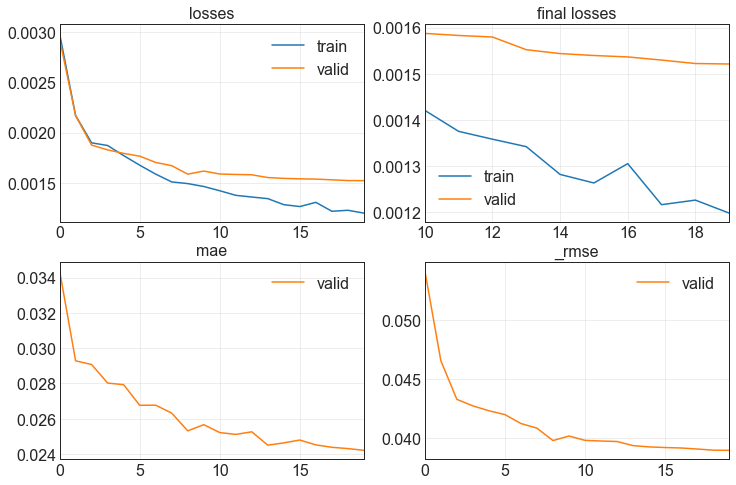

471.69625067710876                                                                                                     
[0.0011981154093518853, 0.0015210560522973537, 0.02421300858259201, 0.03900070860981941]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.01, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 86%|█████████████████████████████████▌     | 86/100 [9:25:56<1:45:49, 453.56s/trial, best loss: 0.0015172121347859502]

No improvement since epoch 6: early stopping                                                                           
 86%|█████████████████████████████████▌     | 86/100 [9:32:09<1:45:49, 453.56s/trial, best loss: 0.0015172121347859502]

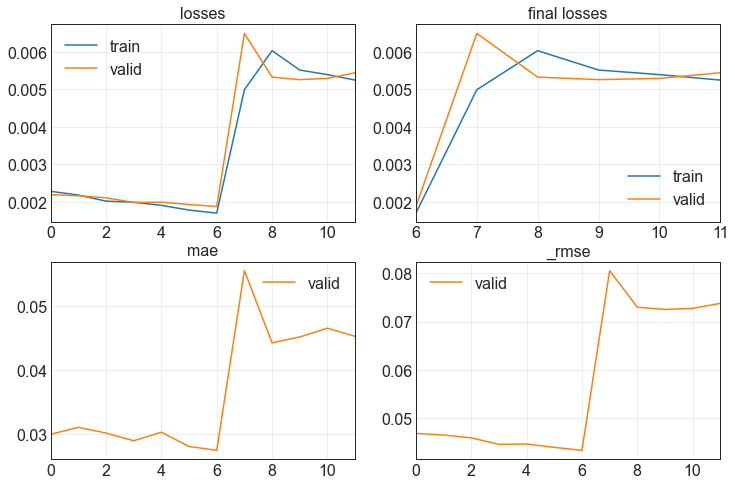

373.83491587638855                                                                                                     
[0.005244405474513769, 0.005441187880933285, 0.04523143917322159, 0.0737643912434578]                                  
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 64, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 87%|█████████████████████████████████▉     | 87/100 [9:32:14<1:33:24, 431.08s/trial, best loss: 0.0015172121347859502]

No improvement since epoch 41: early stopping                                                                          
 87%|█████████████████████████████████▉     | 87/100 [9:34:46<1:33:24, 431.08s/trial, best loss: 0.0015172121347859502]

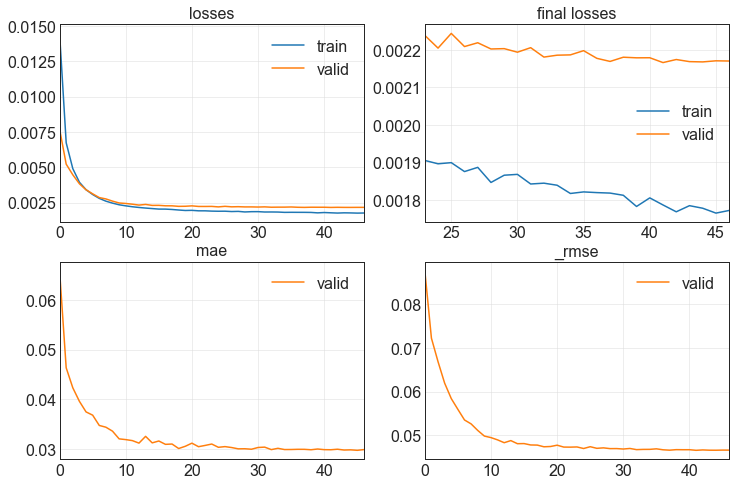

152.48152589797974                                                                                                     
[0.0017719607567414641, 0.0021700444631278515, 0.029919050633907318, 0.04658373072743416]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 10}
TST                                                                                                                    
 88%|██████████████████████████████████▎    | 88/100 [9:34:52<1:09:47, 348.94s/trial, best loss: 0.0015172121347859502]

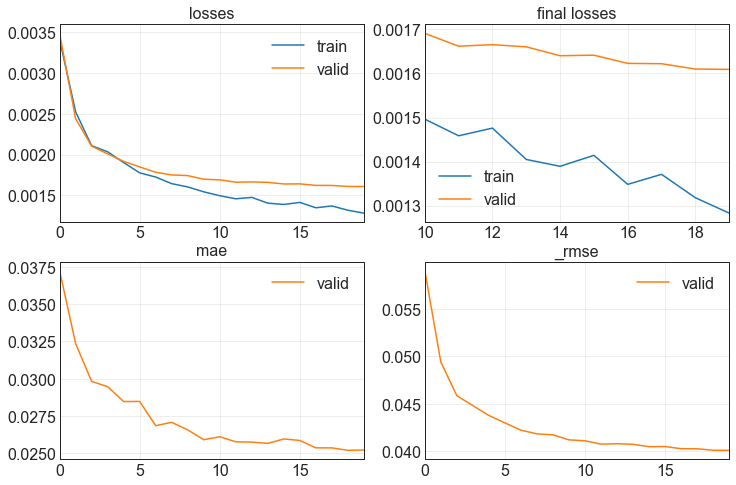

468.44561076164246                                                                                                     
[0.0012831116328015924, 0.0016092080622911453, 0.02523093670606613, 0.040114935487508774]                              
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 20, 'lr': 0.1, 'n_heads': 8, 'n_layers': 5, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 89%|██████████████████████████████████▋    | 89/100 [9:42:45<1:10:48, 386.21s/trial, best loss: 0.0015172121347859502]

No improvement since epoch 1: early stopping                                                                           
 89%|██████████████████████████████████▋    | 89/100 [9:44:08<1:10:48, 386.21s/trial, best loss: 0.0015172121347859502]

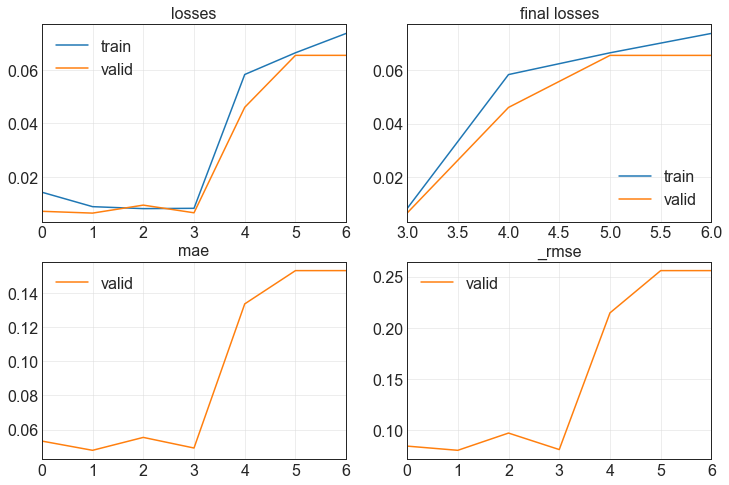

83.28902053833008                                                                                                      
[0.0737176313996315, 0.0655006542801857, 0.15301644802093506, 0.25593093037605286]                                     
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 100, 'lr': 0.001, 'n_heads': 32, 'n_layers': 4, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 90%|████████████████████████████████████▉    | 90/100 [9:44:13<49:27, 296.76s/trial, best loss: 0.0015172121347859502]

No improvement since epoch 16: early stopping                                                                          
 90%|████████████████████████████████████▉    | 90/100 [9:58:18<49:27, 296.76s/trial, best loss: 0.0015172121347859502]

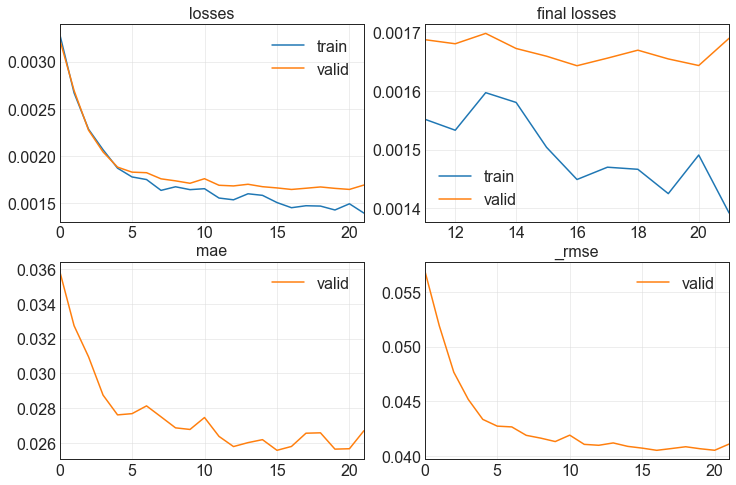

845.3127107620239                                                                                                      
[0.0013919424964115024, 0.001690010423772037, 0.026707792654633522, 0.04110972210764885]                               
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 1, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 91%|███████████████████████████████████▍   | 91/100 [9:58:23<1:09:24, 462.73s/trial, best loss: 0.0015172121347859502]

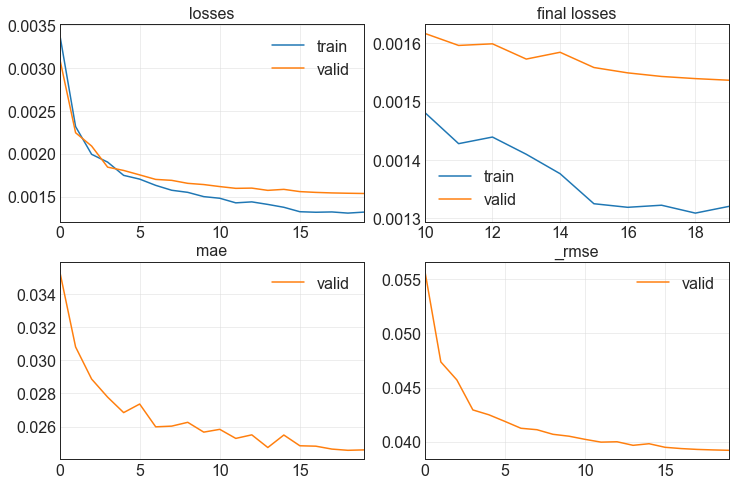

164.94221997261047                                                                                                     
[0.001319962670095265, 0.0015367224114015698, 0.024597061797976494, 0.039201050996780396]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 64, 'epochs': 50, 'lr': 0.01, 'n_heads': 16, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 10}
TST                                                                                                                    
 92%|████████████████████████████████████▊   | 92/100 [10:01:13<49:58, 374.83s/trial, best loss: 0.0015172121347859502]

No improvement since epoch 34: early stopping                                                                          
 92%|████████████████████████████████████▊   | 92/100 [10:18:29<49:58, 374.83s/trial, best loss: 0.0015172121347859502]

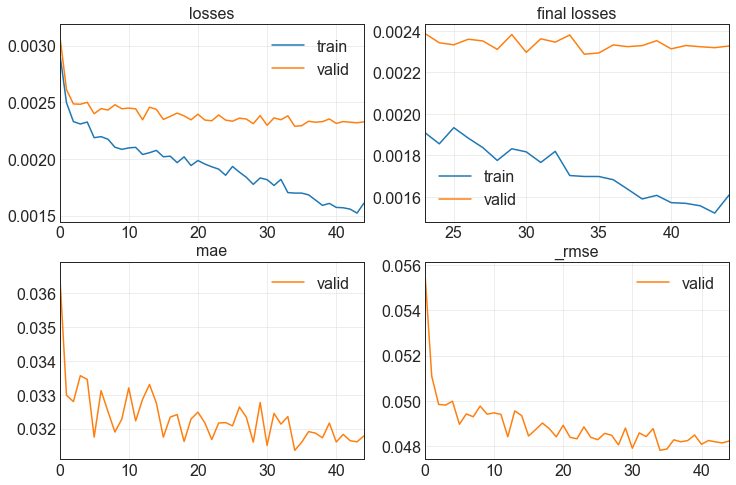

1036.428346157074                                                                                                      
[0.0016090974677354097, 0.0023268309887498617, 0.03178548440337181, 0.04823724552989006]                               
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 93%|███████████████████████████████████▎  | 93/100 [10:18:34<1:07:03, 574.73s/trial, best loss: 0.0015172121347859502]

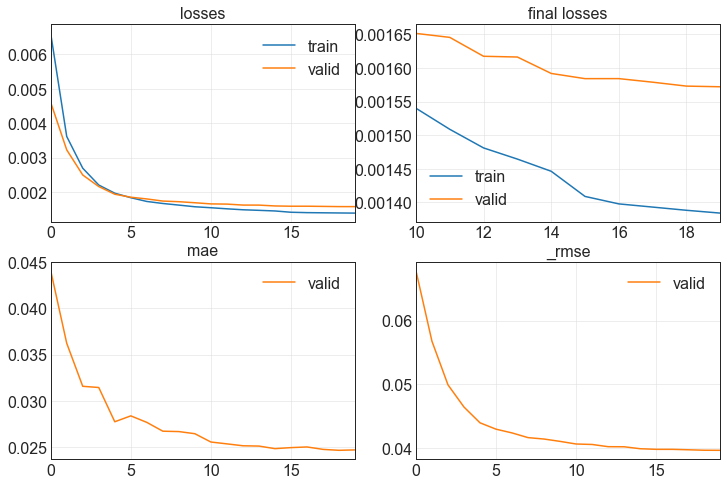

90.25425791740417                                                                                                      
[0.0013838887680321932, 0.001572085078805685, 0.024708783254027367, 0.03964952379465103]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 94%|█████████████████████████████████████▌  | 94/100 [10:20:09<43:04, 430.83s/trial, best loss: 0.0015172121347859502]

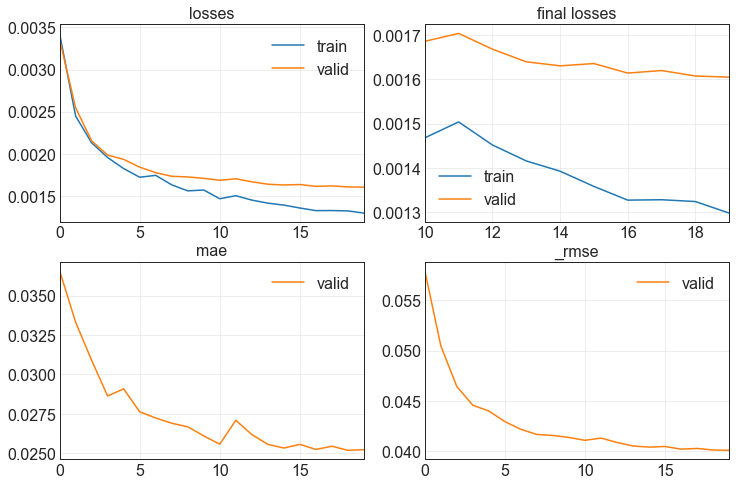

468.5073490142822                                                                                                      
[0.0012973204720765352, 0.0016052605351433158, 0.02522461675107479, 0.040065698325634]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 100, 'lr': 0.1, 'n_heads': 8, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 95%|██████████████████████████████████████  | 95/100 [10:28:02<36:57, 443.54s/trial, best loss: 0.0015172121347859502]

No improvement since epoch 3: early stopping                                                                           
 95%|██████████████████████████████████████  | 95/100 [10:28:57<36:57, 443.54s/trial, best loss: 0.0015172121347859502]

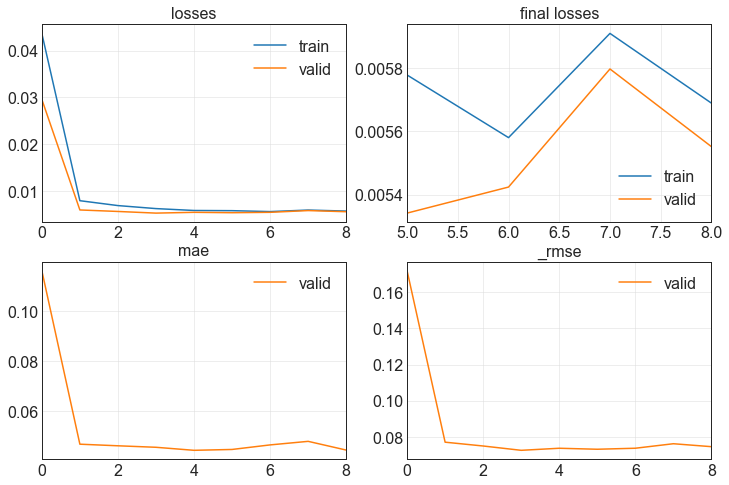

55.72062063217163                                                                                                      
[0.00568936113268137, 0.005551671609282494, 0.04442155733704567, 0.07450953125953674]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 5, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 96%|██████████████████████████████████████▍ | 96/100 [10:29:02<21:54, 328.62s/trial, best loss: 0.0015172121347859502]

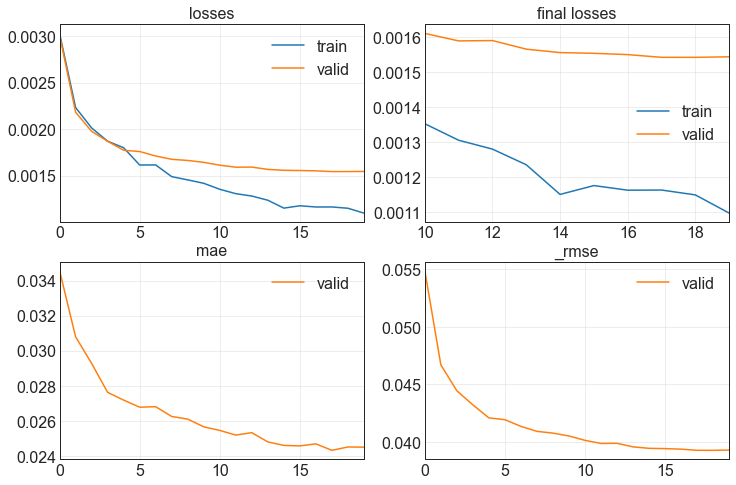

914.3850886821747                                                                                                      
[0.0010966312838718295, 0.0015446633333340287, 0.02449358068406582, 0.039302196353673935]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.01, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 10}
TST                                                                                                                    
 97%|██████████████████████████████████████▊ | 97/100 [10:44:22<25:17, 505.76s/trial, best loss: 0.0015172121347859502]

No improvement since epoch 1: early stopping                                                                           
 97%|██████████████████████████████████████▊ | 97/100 [10:49:06<25:17, 505.76s/trial, best loss: 0.0015172121347859502]

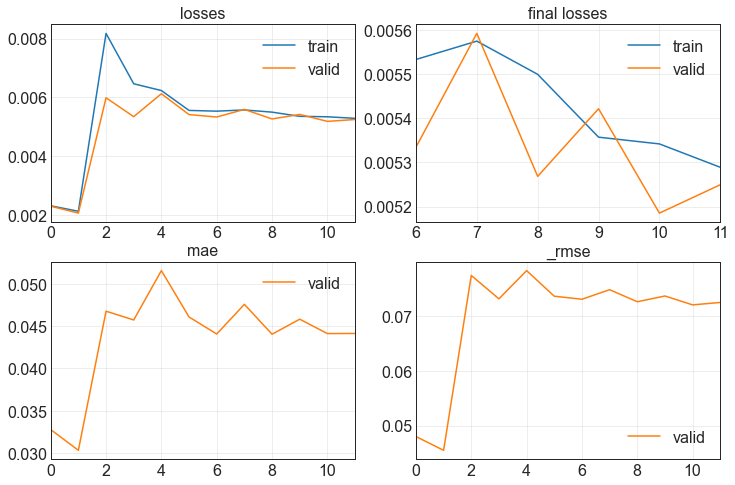

285.026029586792                                                                                                       
[0.005288905464112759, 0.00524947652593255, 0.04413378983736038, 0.07245327532291412]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 64, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 98%|███████████████████████████████████████▏| 98/100 [10:49:11<14:41, 440.96s/trial, best loss: 0.0015172121347859502]

No improvement since epoch 26: early stopping                                                                          
 98%|███████████████████████████████████████▏| 98/100 [10:59:45<14:41, 440.96s/trial, best loss: 0.0015172121347859502]

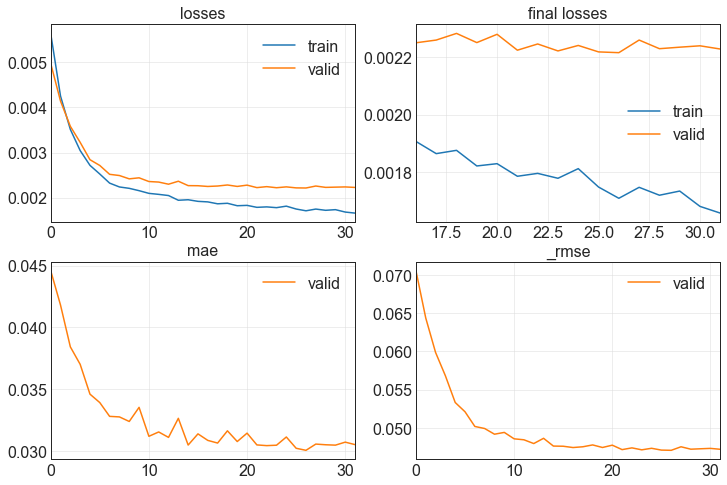

634.232842206955                                                                                                       
[0.0016585019184276462, 0.0022276854142546654, 0.030508996918797493, 0.04719835892319679]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 1, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}
TST                                                                                                                    
 99%|███████████████████████████████████████▌| 99/100 [10:59:50<08:20, 500.38s/trial, best loss: 0.0015172121347859502]

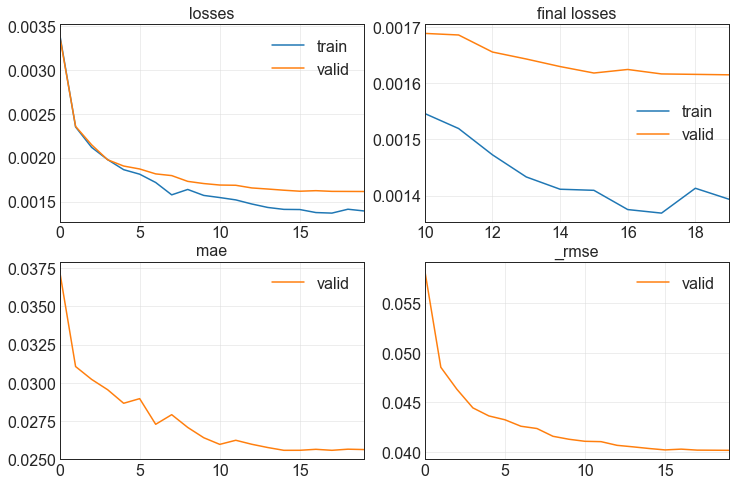

321.8077771663666                                                                                                      
[0.0013932733563706279, 0.0016148478025570512, 0.025630738586187363, 0.040185168385505676]                             
100%|███████████████████████████████████████| 100/100 [11:05:12<00:00, 399.13s/trial, best loss: 0.0015172121347859502]


In [57]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=max_evals,  # test trials
    trials=trials)

In [58]:
print("Best parameters:")
print(space_eval(search_space, best))
params = space_eval(search_space, best)

Best parameters:
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x00000254581DB438>, 'patience': 5}


In [59]:
# only for debug
# params = {'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': Adam, 'patience': 10}

# Retrain the model with best hyperparameter

We use training data for training and validation data for (possible) early stopping:

In [60]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [61]:
X.shape

(38467, 144, 10)

In [62]:
y.shape

(38467, 144)

In [63]:
batch_size = params["batch_size"]

In [64]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
# set num_workers for memory bottleneck
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)

Create the model:

In [65]:
arch = TST
k = {
    'n_layers': params['n_layers'],
    'd_model': params['d_model'],
    'n_heads': params['n_heads']
}
model = create_model(arch, dls=dls, **k)
print(model.__class__.__name__)

TST


In [66]:
# Add a Sigmoid layer
model = nn.Sequential(model, nn.Sigmoid())

In [67]:
model

Sequential(
  (0): TST(
    (W_P): Linear(in_features=144, out_features=256, bias=True)
    (res_dropout): Dropout(p=0.1, inplace=False)
    (encoder): _TSTEncoder(
      (layers): ModuleList(
        (0): _TSTEncoderLayer(
          (self_attn): _MultiHeadAttention(
            (W_Q): Linear(in_features=256, out_features=256, bias=False)
            (W_K): Linear(in_features=256, out_features=256, bias=False)
            (W_V): Linear(in_features=256, out_features=256, bias=False)
            (W_O): Linear(in_features=256, out_features=256, bias=False)
          )
          (dropout_attn): Dropout(p=0.1, inplace=False)
          (batchnorm_attn): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (ff): Sequential(
            (0): Linear(in_features=256, out_features=256, bias=True)
            (1): GELU()
            (2): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout_ffn): Dropout(p=0.1, inplace=False)
     

In [68]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

1,196,000 total parameters.
1,196,000 training parameters.


Training the model:

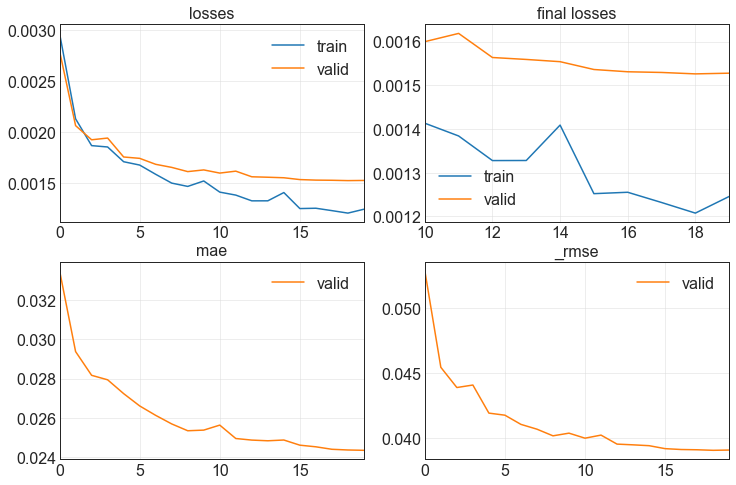

In [69]:
learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
start = time.time()
learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                    cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
training_time = time.time() - start
learn.plot_metrics()

Evaluate the model:

In [70]:
dls = learn.dls
valid_dl = dls.valid

In [71]:
test_ds = valid_dl.dataset.add_test(X_test, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

9619


In [72]:
start = time.time()
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
prediction_time = time.time() - start
test_probas, test_targets, test_preds

(tensor([[0.0071, 0.0153, 0.0413,  ..., 0.0228, 0.2072, 0.8874],
         [0.0084, 0.0136, 0.0364,  ..., 0.0218, 0.1954, 0.8751],
         [0.0062, 0.0192, 0.0265,  ..., 0.0257, 0.1936, 0.8258],
         ...,
         [0.3192, 0.0334, 0.1037,  ..., 0.0715, 0.3856, 0.9786],
         [0.3175, 0.0260, 0.1067,  ..., 0.0779, 0.3378, 0.9593],
         [0.3205, 0.0306, 0.1487,  ..., 0.0877, 0.3651, 0.9397]]),
 tensor([[0.0000, 0.0020, 0.0167,  ..., 0.0065, 0.2165, 0.8989],
         [0.0000, 0.0040, 0.0109,  ..., 0.0057, 0.2154, 0.7845],
         [0.0000, 0.0020, 0.0082,  ..., 0.0079, 0.2064, 1.0000],
         ...,
         [0.6255, 0.0400, 0.1464,  ..., 0.0790, 0.4122, 0.8162],
         [0.6294, 0.0634, 0.2009,  ..., 0.0886, 0.4169, 0.7650],
         [0.4050, 0.0551, 0.1543,  ..., 0.0931, 0.3980, 0.9314]]),
 tensor([[0.0071, 0.0153, 0.0413,  ..., 0.0228, 0.2072, 0.8874],
         [0.0084, 0.0136, 0.0364,  ..., 0.0218, 0.1954, 0.8751],
         [0.0062, 0.0192, 0.0265,  ..., 0.0257, 0.1936, 0.

In [73]:
test_targets.shape

torch.Size([9619, 144])

In [74]:
test_preds.shape

torch.Size([9619, 144])

In [75]:
y_true = test_targets.numpy()
y_pred = test_preds.numpy()

Reshape the data into multiple steps

In [76]:
y_true = y_true.reshape(y_true.shape[0], horizon, -1)
y_pred = y_pred.reshape(y_pred.shape[0], horizon, -1)

In [77]:
y_true.shape

(9619, 1, 144)

In [78]:
y_pred.shape

(9619, 1, 144)

Transform the data in the normal range:

In [79]:
def inverse_normalization(prediction, y, max_list, min_list):
    inverse_prediction = prediction * (max_list - min_list) + min_list
    inverse_y = y * (max_list - min_list) + min_list

    return inverse_prediction, inverse_y

In [80]:
y_true_list = []
y_pred_list = []
for i in range(y_true.shape[0]):
    y_true_tmp = []
    y_pred_tmp = []
    for step in range(y_true.shape[1]):
        inverse_prediction, inverse_y = inverse_normalization(y_pred[i, step, :], y_true[i, step, :], max_list, min_list)
        
        y_true_tmp.append(inverse_y)
        y_pred_tmp.append(inverse_prediction)
    y_true_list.append(y_true_tmp)
    y_pred_list.append(y_pred_tmp)

In [81]:
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

In [82]:
y_true.shape

(9619, 1, 144)

In [83]:
y_pred.shape

(9619, 1, 144)

# Save Predictions and Evaluate Model

Save true values and predictions first:

In [84]:
pickle.dump(y_pred, open(y_pred_fn, 'wb'))

In [85]:
pickle.dump(y_true, open(y_true_fn, 'wb'))

The training and test time spent:

In [86]:
print('Training time (in seconds): ', training_time)
print('Test time (in seconds): ', prediction_time)

Training time (in seconds):  476.94161105155945
Test time (in seconds):  2.9295613765716553


In [92]:
print('Training time (in seconds) per epoch: ', 476.94161105155945 / 20)

Training time (in seconds) per epoch:  23.84708055257797


Calculate the RMSE and MAE for differnt time steps:

In [88]:
for step in range(horizon):
    print('Prediction for the next %d frame' % (step + 1))
    print('RMSE: ', math.sqrt(mean_squared_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten())) / 1000)  # in Mbps
    print('MAE: ', mean_absolute_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten()) / 1000 )

Prediction for the next 1 frame
RMSE:  8.514833744165061
MAE:  4.086793473596728


Plot the RMSE and MAE distributions for each time step:

In [89]:
def plot_RMSE(y_true, y_pred, fn, xlim=60):
    RMSE_list = []

    for i in range(y_true.shape[0]):
        rmse = math.sqrt(mean_squared_error(y_true[i].flatten(), y_pred[i].flatten())) / 1000
        RMSE_list.append(rmse)
    
    data = RMSE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("RMSE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

In [90]:
def plot_MAE(y_true, y_pred, fn, xlim=60):
    MAE_list = []

    for i in range(y_true.shape[0]):
        mae = mean_absolute_error(y_true[i].flatten(), y_pred[i].flatten()) / 1000
        MAE_list.append(mae)
    
    data = MAE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("MAE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

TST_TM-minmax_RMSE-10-1-step-1.pdf
TST_TM-minmax_MAE-10-1-step-1.pdf


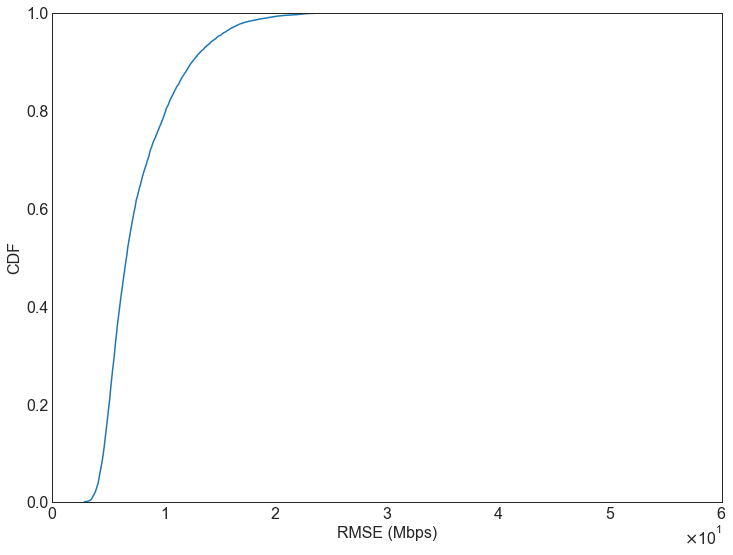

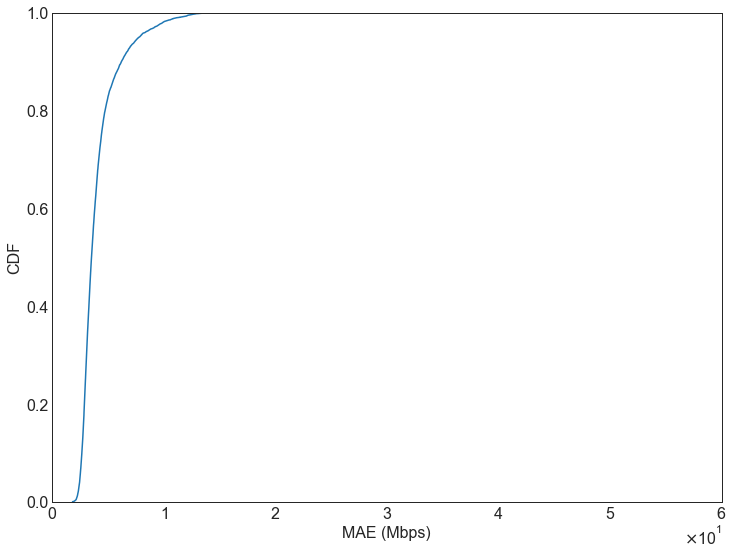

In [91]:
for step in range(horizon):
    fn = RMSE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_RMSE(y_true[:, step, :], y_pred[:, step, :], fn)
    
    fn = MAE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_MAE(y_true[:, step, :], y_pred[:, step, :], fn)